In [1]:
import importlib

from keras.layers import Input, Embedding, GRU, Bidirectional, Dense, Lambda
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
import keras.backend as K
from keras.utils import plot_model

import numpy as np
import random
import pickle as pkl

from qgen.data import training_data, test_data, collapse_documents, expand_answers, _read_data

import qgen.utils as utils
from qgen.embedding import glove

import matplotlib.pyplot as plt

/Users/davidfoster/.virtualenvs/gdl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#### PARAMETERS ####

VOCAB_SIZE = glove.shape[0]
EMBEDDING_DIMENS = glove.shape[1]

GRU_UNITS = 100
MAX_DOC_SIZE = None
MAX_ANSWER_SIZE = None
MAX_Q_SIZE = None


In [3]:
#### TRAINING MODEL ####

document_tokens = Input(shape=(MAX_DOC_SIZE,), name="document_tokens")

embedding = Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIMENS, weights=[glove], mask_zero = True, name = 'embedding')
document_emb = embedding(document_tokens)

answer_outputs = Bidirectional(GRU(GRU_UNITS, return_sequences=True), name = 'answer_outputs')(document_emb)
answer_tags = Dense(1, activation = 'sigmoid', name = 'answer_tags')(answer_outputs)

encoder_input_mask = Input(shape=(MAX_ANSWER_SIZE, MAX_DOC_SIZE), name="encoder_input_mask")
encoder_inputs = Lambda(lambda x: K.batch_dot(x[0], x[1]), name="encoder_inputs")([encoder_input_mask, answer_outputs])
encoder_cell = GRU(2 * GRU_UNITS, name = 'encoder_cell')(encoder_inputs)

decoder_inputs = Input(shape=(MAX_Q_SIZE,), name="decoder_inputs")
decoder_emb = embedding(decoder_inputs)
decoder_emb.trainable = False
decoder_cell = GRU(2 * GRU_UNITS, return_sequences = True, name = 'decoder_cell')
decoder_states = decoder_cell(decoder_emb, initial_state = [encoder_cell])

decoder_projection = Dense(VOCAB_SIZE, name = 'decoder_projection', activation = 'softmax')
decoder_outputs = decoder_projection(decoder_states)

total_model = Model([document_tokens, decoder_inputs, encoder_input_mask], [answer_tags, decoder_outputs])
plot_model(total_model, to_file='model.png',show_shapes=True)

In [4]:
#### INFERENCE MODEL ####

decoder_inputs_dynamic = Input(shape=(1,), name="decoder_inputs_dynamic")
decoder_emb_dynamic = embedding(decoder_inputs_dynamic)
decoder_init_state_dynamic = Input(shape=(2 * GRU_UNITS,), name = 'decoder_init_state_dynamic') #the embedding of the previous word
decoder_states_dynamic = decoder_cell(decoder_emb_dynamic, initial_state = [decoder_init_state_dynamic])
decoder_outputs_dynamic = decoder_projection(decoder_states_dynamic)

answer_model = Model(document_tokens, [answer_tags])
decoder_initial_state_model = Model([document_tokens, encoder_input_mask], [encoder_cell])
question_model = Model([decoder_inputs_dynamic, decoder_init_state_dynamic], [decoder_outputs_dynamic, decoder_states_dynamic])



In [5]:
#### COMPILE TRAINING MODEL ####

opti = Adam(lr=0.01)
total_model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
                    , optimizer=opti
                    , loss_weights = [0.5, 0.5]) 


In [6]:
#### LOAD DATA ####

training_data_gen = training_data()
# training_data_gen = [next(training_data_gen)]
test_data_gen = test_data()

training_loss_history = []
test_loss_history = []


In [7]:
#### TRAIN MODEL ####

EPOCHS = 2000

start_epoch = 1

for epoch in range(start_epoch, start_epoch + EPOCHS + 1):
    print("Epoch {0}".format(epoch))
    
    for i, batch in enumerate(training_data()):
        
        val_batch = next(test_data_gen, None)
        
        if val_batch is None:
            test_data_gen = test_data()
            val_batch = next(test_data_gen, None)
            
        training_loss = total_model.train_on_batch(
            [batch['document_tokens'], batch['question_input_tokens'], batch['answer_masks']]
            , [np.expand_dims(batch['answer_labels'], axis = -1), np.expand_dims(batch['question_output_tokens'], axis = -1)]
        )
        
        test_loss = total_model.test_on_batch(
            [val_batch['document_tokens'], val_batch['question_input_tokens'], val_batch['answer_masks']]
            , [np.expand_dims(val_batch['answer_labels'], axis = -1), np.expand_dims(val_batch['question_output_tokens'], axis = -1)]
        )
        
        training_loss_history.append(training_loss)
        test_loss_history.append(test_loss)
        
        print("{}: Train Loss: {} | Test Loss: {}".format(i, training_loss, test_loss))
        
    total_model.save_weights('./saved_models/keras_{}.h5'.format(epoch))
        

Epoch 1
0: Train Loss: [5.055319, 0.9013131, 9.209325] | Test Loss: [4.6524873, 0.6337282, 8.671247]
1: Train Loss: [4.645729, 0.57349265, 8.717965] | Test Loss: [4.212451, 0.91654813, 7.5083537]
2: Train Loss: [3.9394507, 0.4959245, 7.382977] | Test Loss: [3.5608807, 0.60691094, 6.51485]
3: Train Loss: [3.644256, 0.50674725, 6.781765] | Test Loss: [3.3598495, 0.5141988, 6.2055]
4: Train Loss: [3.2938123, 0.42791322, 6.1597114] | Test Loss: [3.341103, 0.45441782, 6.2277884]
5: Train Loss: [3.3498712, 0.4937119, 6.2060304] | Test Loss: [3.3614786, 0.42073113, 6.302226]
6: Train Loss: [3.4325159, 0.40416187, 6.46087] | Test Loss: [3.3437803, 0.33606195, 6.3514986]
7: Train Loss: [3.2320545, 0.41837296, 6.045736] | Test Loss: [3.176444, 0.40054023, 5.9523478]
8: Train Loss: [3.176085, 0.36128604, 5.990884] | Test Loss: [3.278519, 0.44428986, 6.112748]
9: Train Loss: [3.0794191, 0.34687468, 5.8119636] | Test Loss: [3.0889208, 0.4403595, 5.737482]
10: Train Loss: [3.1363404, 0.38268307, 5.8

85: Train Loss: [2.6526804, 0.2948496, 5.0105114] | Test Loss: [2.660247, 0.49524742, 4.825247]
86: Train Loss: [2.5958748, 0.31106848, 4.880681] | Test Loss: [2.584488, 0.37291935, 4.7960563]
87: Train Loss: [2.769708, 0.47719997, 5.062216] | Test Loss: [2.8525686, 0.38720262, 5.3179345]
88: Train Loss: [2.6464107, 0.3200336, 4.972788] | Test Loss: [2.6819835, 0.30170405, 5.062263]
89: Train Loss: [2.5803497, 0.32862324, 4.832076] | Test Loss: [2.731052, 0.33953255, 5.1225715]
90: Train Loss: [2.645426, 0.33985677, 4.9509954] | Test Loss: [2.814649, 0.36767998, 5.261618]
91: Train Loss: [2.9283485, 0.33476737, 5.5219297] | Test Loss: [2.5859823, 0.29519323, 4.8767715]
92: Train Loss: [2.8007555, 0.34852093, 5.2529902] | Test Loss: [2.7390277, 0.32921946, 5.148836]
93: Train Loss: [2.5624309, 0.3102621, 4.8145995] | Test Loss: [2.7416704, 0.31216538, 5.1711755]
94: Train Loss: [2.7050676, 0.33830258, 5.0718327] | Test Loss: [2.5525413, 0.34352258, 4.76156]
95: Train Loss: [2.635787, 0.

169: Train Loss: [2.508101, 0.34908375, 4.667118] | Test Loss: [2.673772, 0.35317004, 4.9943743]
170: Train Loss: [2.6697993, 0.29691604, 5.0426826] | Test Loss: [2.7152987, 0.4119308, 5.0186663]
171: Train Loss: [2.7387981, 0.31426993, 5.1633263] | Test Loss: [2.6118965, 0.3036591, 4.920134]
172: Train Loss: [2.4990873, 0.32007435, 4.6781] | Test Loss: [2.646851, 0.31062755, 4.9830747]
173: Train Loss: [2.6097302, 0.2944859, 4.9249744] | Test Loss: [2.703979, 0.36612782, 5.04183]
174: Train Loss: [2.567686, 0.3002893, 4.835083] | Test Loss: [2.6783412, 0.3508335, 5.005849]
175: Train Loss: [2.5706463, 0.352751, 4.788542] | Test Loss: [2.6011753, 0.3554986, 4.846852]
176: Train Loss: [2.4475102, 0.40745613, 4.4875646] | Test Loss: [2.7717779, 0.3841856, 5.15937]
177: Train Loss: [2.6920216, 0.35200536, 5.0320377] | Test Loss: [2.6315525, 0.37767202, 4.8854327]
178: Train Loss: [2.4624074, 0.30931598, 4.6154985] | Test Loss: [2.708766, 0.33253777, 5.0849943]
179: Train Loss: [2.697846, 

253: Train Loss: [2.34475, 0.33213338, 4.3573666] | Test Loss: [2.4903283, 0.340457, 4.6401997]
254: Train Loss: [2.3680434, 0.35405302, 4.382034] | Test Loss: [2.4544168, 0.45352268, 4.455311]
255: Train Loss: [2.4240885, 0.4303476, 4.4178295] | Test Loss: [2.4911647, 0.26460043, 4.717729]
256: Train Loss: [2.3941095, 0.30286512, 4.485354] | Test Loss: [2.5898638, 0.3939936, 4.785734]
257: Train Loss: [2.2339492, 0.29505423, 4.172844] | Test Loss: [2.449703, 0.45945886, 4.439947]
258: Train Loss: [2.4673, 0.32269877, 4.6119013] | Test Loss: [2.4129095, 0.3736065, 4.4522123]
259: Train Loss: [2.6065426, 0.34719497, 4.86589] | Test Loss: [2.4511094, 0.35379532, 4.5484233]
260: Train Loss: [2.337016, 0.27221477, 4.4018173] | Test Loss: [2.3199697, 0.3244065, 4.3155327]
261: Train Loss: [2.4235518, 0.34849885, 4.498605] | Test Loss: [2.5649385, 0.37058014, 4.759297]
262: Train Loss: [2.4054549, 0.33079463, 4.480115] | Test Loss: [2.3985288, 0.28080076, 4.516257]
263: Train Loss: [2.327477

337: Train Loss: [2.5148623, 0.39101228, 4.6387124] | Test Loss: [2.2829206, 0.4545037, 4.1113377]
338: Train Loss: [2.3310208, 0.3243872, 4.3376546] | Test Loss: [2.2912347, 0.3474532, 4.2350163]
339: Train Loss: [2.2094767, 0.33343962, 4.0855136] | Test Loss: [2.2737958, 0.40674734, 4.1408443]
340: Train Loss: [2.4527984, 0.50140214, 4.404195] | Test Loss: [2.3342957, 0.2940451, 4.3745465]
341: Train Loss: [2.2033916, 0.30782413, 4.098959] | Test Loss: [2.3073678, 0.32720342, 4.2875323]
342: Train Loss: [2.3818429, 0.36833185, 4.395354] | Test Loss: [2.2890506, 0.3646199, 4.2134814]
343: Train Loss: [2.2671547, 0.33171862, 4.202591] | Test Loss: [2.370292, 0.37292942, 4.3676543]
344: Train Loss: [2.2246704, 0.31633234, 4.1330085] | Test Loss: [2.2450786, 0.28792432, 4.202233]
345: Train Loss: [2.3452013, 0.29273525, 4.3976674] | Test Loss: [2.2696724, 0.34152192, 4.197823]
346: Train Loss: [2.3724842, 0.3216529, 4.4233155] | Test Loss: [2.4694827, 0.32349443, 4.615471]
347: Train Los

421: Train Loss: [2.3881717, 0.3104867, 4.4658566] | Test Loss: [2.3225002, 0.35710064, 4.2879]
422: Train Loss: [2.233052, 0.33384806, 4.132256] | Test Loss: [2.2620344, 0.3390409, 4.185028]
423: Train Loss: [2.2849429, 0.34174076, 4.228145] | Test Loss: [2.2431018, 0.38045815, 4.1057453]
424: Train Loss: [2.1968741, 0.23242506, 4.161323] | Test Loss: [2.3352742, 0.36024404, 4.310304]
425: Train Loss: [2.1373067, 0.34982482, 3.9247887] | Test Loss: [2.3132818, 0.35034287, 4.276221]
426: Train Loss: [2.3068998, 0.36007735, 4.253722] | Test Loss: [2.3149748, 0.36787048, 4.2620792]
427: Train Loss: [2.4659863, 0.40668553, 4.525287] | Test Loss: [2.2851782, 0.30446506, 4.2658916]
428: Train Loss: [2.2713454, 0.30849457, 4.234196] | Test Loss: [2.194476, 0.35585362, 4.033098]
429: Train Loss: [2.473399, 0.35306033, 4.5937376] | Test Loss: [2.2648926, 0.3224879, 4.2072973]
430: Train Loss: [2.1043403, 0.31966412, 3.8890166] | Test Loss: [2.170065, 0.35668725, 3.9834428]
431: Train Loss: [2.

505: Train Loss: [2.2572124, 0.3221608, 4.192264] | Test Loss: [2.1395195, 0.28802568, 3.9910133]
506: Train Loss: [2.2037778, 0.32957363, 4.077982] | Test Loss: [2.245999, 0.3169309, 4.1750674]
507: Train Loss: [2.2517517, 0.35897243, 4.144531] | Test Loss: [2.2266693, 0.3424825, 4.110856]
508: Train Loss: [2.3292267, 0.3502007, 4.308253] | Test Loss: [2.32828, 0.36989453, 4.2866654]
509: Train Loss: [2.1521046, 0.33638197, 3.9678273] | Test Loss: [2.2192605, 0.28077707, 4.157744]
510: Train Loss: [2.2454815, 0.36328545, 4.1276774] | Test Loss: [2.2896342, 0.39897668, 4.1802917]
511: Train Loss: [2.3437276, 0.35027683, 4.337178] | Test Loss: [2.092229, 0.31951806, 3.86494]
512: Train Loss: [2.1759932, 0.3186757, 4.033311] | Test Loss: [2.1953964, 0.3786872, 4.0121055]
513: Train Loss: [2.336413, 0.37200266, 4.300823] | Test Loss: [2.2929313, 0.32436913, 4.2614937]
514: Train Loss: [2.3381195, 0.39557174, 4.2806673] | Test Loss: [2.357184, 0.35480452, 4.3595634]
515: Train Loss: [2.250

66: Train Loss: [2.1470296, 0.26353565, 4.030524] | Test Loss: [2.2006748, 0.4325229, 3.9688265]
67: Train Loss: [2.0752041, 0.2907945, 3.8596137] | Test Loss: [2.3671439, 0.2866346, 4.4476533]
68: Train Loss: [2.23671, 0.31121686, 4.1622033] | Test Loss: [2.2703562, 0.3114215, 4.229291]
69: Train Loss: [2.1535962, 0.32429352, 3.982899] | Test Loss: [2.2596612, 0.3989119, 4.1204104]
70: Train Loss: [2.108574, 0.2915375, 3.9256103] | Test Loss: [2.1287112, 0.26601002, 3.9914124]
71: Train Loss: [2.166471, 0.43794093, 3.8950012] | Test Loss: [2.156555, 0.30039173, 4.012718]
72: Train Loss: [2.2276835, 0.36363044, 4.091737] | Test Loss: [2.1892004, 0.37303466, 4.0053663]
73: Train Loss: [2.1882966, 0.37861302, 3.99798] | Test Loss: [2.3486784, 0.35808316, 4.3392735]
74: Train Loss: [2.164232, 0.3336829, 3.9947813] | Test Loss: [2.2113492, 0.3183631, 4.1043353]
75: Train Loss: [2.068724, 0.31079584, 3.8266518] | Test Loss: [2.2953594, 0.429185, 4.161534]
76: Train Loss: [2.1430385, 0.31646

151: Train Loss: [2.2085426, 0.26674587, 4.150339] | Test Loss: [2.1972218, 0.3381278, 4.056316]
152: Train Loss: [2.164415, 0.37177554, 3.9570544] | Test Loss: [2.2796626, 0.3393875, 4.219938]
153: Train Loss: [2.0773075, 0.3042247, 3.8503904] | Test Loss: [2.3332305, 0.33267325, 4.333788]
154: Train Loss: [2.2814684, 0.31149104, 4.251446] | Test Loss: [2.1682124, 0.27998316, 4.056442]
155: Train Loss: [2.1777859, 0.36602902, 3.9895427] | Test Loss: [2.211525, 0.37027425, 4.052776]
156: Train Loss: [2.178342, 0.30954054, 4.0471435] | Test Loss: [2.2296154, 0.2833287, 4.1759024]
157: Train Loss: [2.2490144, 0.32285872, 4.17517] | Test Loss: [2.116263, 0.4133084, 3.8192172]
158: Train Loss: [2.1239777, 0.31447124, 3.9334843] | Test Loss: [2.1690278, 0.35891548, 3.9791403]
159: Train Loss: [2.187044, 0.2898513, 4.0842366] | Test Loss: [2.3594499, 0.3444171, 4.3744826]
160: Train Loss: [2.0151365, 0.32813567, 3.7021375] | Test Loss: [2.2526345, 0.3291712, 4.176098]
161: Train Loss: [2.188

235: Train Loss: [2.240617, 0.3587879, 4.122446] | Test Loss: [2.1342804, 0.35021594, 3.918345]
236: Train Loss: [2.173322, 0.3373726, 4.009271] | Test Loss: [2.2238464, 0.4049013, 4.0427914]
237: Train Loss: [2.1096094, 0.38518175, 3.8340368] | Test Loss: [2.3583627, 0.29733965, 4.419386]
238: Train Loss: [2.1119132, 0.35476905, 3.8690574] | Test Loss: [2.220284, 0.38992232, 4.050646]
239: Train Loss: [2.1983125, 0.30458337, 4.0920415] | Test Loss: [2.2530687, 0.30675027, 4.199387]
240: Train Loss: [2.1113377, 0.29978356, 3.9228916] | Test Loss: [2.1688397, 0.32237345, 4.015306]
241: Train Loss: [2.2646546, 0.36677542, 4.1625338] | Test Loss: [2.224484, 0.33807507, 4.110893]
242: Train Loss: [2.0984163, 0.3861726, 3.8106601] | Test Loss: [2.2056987, 0.33478206, 4.0766153]
243: Train Loss: [2.1377294, 0.25788686, 4.017572] | Test Loss: [2.201402, 0.31748256, 4.0853214]
244: Train Loss: [2.0465078, 0.31343764, 3.7795782] | Test Loss: [2.2646906, 0.36362013, 4.165761]
245: Train Loss: [2

319: Train Loss: [2.1936336, 0.31530562, 4.0719614] | Test Loss: [2.2423613, 0.35882628, 4.1258965]
320: Train Loss: [2.212452, 0.3399877, 4.084916] | Test Loss: [2.3449259, 0.31785962, 4.371992]
321: Train Loss: [2.068736, 0.323907, 3.813565] | Test Loss: [2.2576346, 0.3480336, 4.167236]
322: Train Loss: [2.1760907, 0.32246435, 4.029717] | Test Loss: [2.3208344, 0.3858021, 4.2558665]
323: Train Loss: [2.1130738, 0.36258352, 3.8635643] | Test Loss: [2.1284761, 0.3242088, 3.9327433]
324: Train Loss: [2.216496, 0.30414432, 4.1288476] | Test Loss: [2.215031, 0.35277072, 4.077291]
325: Train Loss: [2.2491817, 0.34231257, 4.156051] | Test Loss: [2.2186913, 0.40581173, 4.031571]
326: Train Loss: [2.2569373, 0.35391062, 4.159964] | Test Loss: [2.2582672, 0.34009114, 4.176443]
327: Train Loss: [2.1341503, 0.27886152, 3.989439] | Test Loss: [2.3546746, 0.32030228, 4.3890467]
328: Train Loss: [2.152347, 0.3412652, 3.9634287] | Test Loss: [2.0331676, 0.2759158, 3.7904193]
329: Train Loss: [2.2128

403: Train Loss: [2.1603587, 0.35181007, 3.9689074] | Test Loss: [2.3033252, 0.33421186, 4.2724385]
404: Train Loss: [2.0441234, 0.37173793, 3.7165089] | Test Loss: [2.2144232, 0.32511196, 4.1037345]
405: Train Loss: [2.0977266, 0.33651048, 3.8589427] | Test Loss: [2.403656, 0.28641126, 4.5209007]
406: Train Loss: [2.047799, 0.32615438, 3.769444] | Test Loss: [2.3631053, 0.3081938, 4.418017]
407: Train Loss: [2.280167, 0.35538006, 4.204954] | Test Loss: [2.2406507, 0.30920815, 4.172093]
408: Train Loss: [2.2293563, 0.36487994, 4.0938325] | Test Loss: [2.2329335, 0.40391898, 4.061948]
409: Train Loss: [2.222313, 0.34834027, 4.096286] | Test Loss: [2.1154695, 0.311778, 3.919161]
410: Train Loss: [2.1447453, 0.28649533, 4.0029955] | Test Loss: [2.129542, 0.38808125, 3.871003]
411: Train Loss: [2.0172887, 0.34496084, 3.6896164] | Test Loss: [2.1204624, 0.3115851, 3.92934]
412: Train Loss: [2.1452022, 0.28986597, 4.0005383] | Test Loss: [2.2023373, 0.33610386, 4.0685706]
413: Train Loss: [2

487: Train Loss: [2.2450178, 0.36724913, 4.1227865] | Test Loss: [2.1614082, 0.3647803, 3.9580362]
488: Train Loss: [2.1536975, 0.3207285, 3.9866664] | Test Loss: [2.1428912, 0.32063907, 3.9651432]
489: Train Loss: [2.1926801, 0.37813932, 4.0072207] | Test Loss: [2.2900522, 0.35930258, 4.220802]
490: Train Loss: [2.0871537, 0.35090148, 3.8234057] | Test Loss: [2.1906462, 0.38952637, 3.9917662]
491: Train Loss: [2.2328012, 0.3557877, 4.1098146] | Test Loss: [2.0752068, 0.34977078, 3.800643]
492: Train Loss: [2.186262, 0.41551903, 3.9570048] | Test Loss: [2.4193673, 0.34648603, 4.4922485]
493: Train Loss: [2.172015, 0.33151156, 4.0125184] | Test Loss: [2.1441977, 0.32233176, 3.9660637]
494: Train Loss: [2.1647851, 0.29991323, 4.029657] | Test Loss: [2.118313, 0.38751373, 3.8491125]
495: Train Loss: [2.1114938, 0.27012125, 3.9528663] | Test Loss: [2.187499, 0.3753004, 3.9996977]
496: Train Loss: [2.2552052, 0.26401144, 4.246399] | Test Loss: [2.272588, 0.3343964, 4.2107797]
497: Train Los

47: Train Loss: [2.06464, 0.30505258, 3.8242273] | Test Loss: [2.1625593, 0.31274697, 4.0123715]
48: Train Loss: [2.0954647, 0.29545125, 3.8954782] | Test Loss: [2.284873, 0.27620223, 4.293544]
49: Train Loss: [2.0242348, 0.4898557, 3.558614] | Test Loss: [2.2350705, 0.28371814, 4.186423]
50: Train Loss: [2.0891185, 0.34248003, 3.8357568] | Test Loss: [2.3727372, 0.34844863, 4.3970256]
51: Train Loss: [1.964387, 0.31399015, 3.614784] | Test Loss: [2.184859, 0.35422972, 4.015488]
52: Train Loss: [1.9172821, 0.3099702, 3.524594] | Test Loss: [2.4103975, 0.42190745, 4.3988876]
53: Train Loss: [2.0255678, 0.32416677, 3.7269688] | Test Loss: [2.2958887, 0.33396095, 4.2578163]
54: Train Loss: [1.9543227, 0.34742856, 3.5612168] | Test Loss: [2.2812176, 0.3380665, 4.2243686]
55: Train Loss: [2.0611637, 0.34613323, 3.776194] | Test Loss: [2.310112, 0.3201691, 4.300055]
56: Train Loss: [2.10536, 0.41999054, 3.7907293] | Test Loss: [2.4896321, 0.37131143, 4.607953]
57: Train Loss: [2.1949153, 0.3

132: Train Loss: [2.0453732, 0.36359572, 3.7271507] | Test Loss: [2.2942502, 0.33545402, 4.2530465]
133: Train Loss: [2.086708, 0.3442908, 3.8291252] | Test Loss: [2.3014653, 0.35737017, 4.24556]
134: Train Loss: [2.1840508, 0.37464765, 3.993454] | Test Loss: [2.3017433, 0.29849437, 4.304992]
135: Train Loss: [1.9981915, 0.31790376, 3.6784792] | Test Loss: [2.1910698, 0.3417288, 4.040411]
136: Train Loss: [2.0778635, 0.31006, 3.8456671] | Test Loss: [2.3550894, 0.29710367, 4.413075]
137: Train Loss: [2.2957246, 0.44257724, 4.148872] | Test Loss: [2.3076303, 0.35195416, 4.2633066]
138: Train Loss: [2.1483386, 0.32085606, 3.975821] | Test Loss: [2.2005863, 0.30769488, 4.0934777]
139: Train Loss: [2.03009, 0.276151, 3.7840292] | Test Loss: [2.4479237, 0.3760351, 4.519812]
140: Train Loss: [2.164731, 0.29483607, 4.034626] | Test Loss: [2.3116963, 0.4058935, 4.2174993]
141: Train Loss: [2.1570063, 0.34876078, 3.9652517] | Test Loss: [2.3192706, 0.37541917, 4.263122]
142: Train Loss: [2.1143

216: Train Loss: [2.1269596, 0.2882127, 3.9657066] | Test Loss: [2.3340082, 0.3039494, 4.364067]
217: Train Loss: [2.11534, 0.3017159, 3.928964] | Test Loss: [2.3390684, 0.45095372, 4.2271833]
218: Train Loss: [1.9047731, 0.30778828, 3.5017579] | Test Loss: [2.2898502, 0.31238645, 4.267314]
219: Train Loss: [2.1362534, 0.3606533, 3.9118536] | Test Loss: [2.2405913, 0.29691994, 4.1842628]
220: Train Loss: [2.1270883, 0.37879682, 3.8753798] | Test Loss: [2.2294304, 0.5306347, 3.9282262]
221: Train Loss: [2.0695088, 0.38324803, 3.7557697] | Test Loss: [2.2528813, 0.32089382, 4.184869]
222: Train Loss: [1.9478796, 0.3532039, 3.542555] | Test Loss: [2.2714105, 0.33710134, 4.2057195]
223: Train Loss: [2.0375187, 0.33648404, 3.7385535] | Test Loss: [2.3771973, 0.37890023, 4.3754945]
224: Train Loss: [2.1797073, 0.323389, 4.0360255] | Test Loss: [2.2281272, 0.352897, 4.1033573]
225: Train Loss: [1.9625169, 0.32689923, 3.5981345] | Test Loss: [2.2185361, 0.3858981, 4.051174]
226: Train Loss: [1

300: Train Loss: [2.0255003, 0.33116272, 3.719838] | Test Loss: [2.1570263, 0.3373388, 3.976714]
301: Train Loss: [2.2057252, 0.39298266, 4.018468] | Test Loss: [2.2046099, 0.34680355, 4.062416]
302: Train Loss: [2.2340539, 0.33818865, 4.129919] | Test Loss: [2.1677465, 0.30097535, 4.034518]
303: Train Loss: [2.0627038, 0.38602158, 3.739386] | Test Loss: [2.0298686, 0.37698576, 3.6827517]
304: Train Loss: [2.0203893, 0.31196034, 3.7288182] | Test Loss: [2.3682485, 0.38584006, 4.350657]
305: Train Loss: [2.2136247, 0.30423674, 4.1230125] | Test Loss: [2.2894258, 0.34034222, 4.2385097]
306: Train Loss: [2.1460762, 0.3510776, 3.9410748] | Test Loss: [2.2373, 0.33522272, 4.139377]
307: Train Loss: [2.0591497, 0.4281826, 3.6901166] | Test Loss: [2.3519034, 0.3304534, 4.3733535]
308: Train Loss: [1.9770011, 0.2627925, 3.6912096] | Test Loss: [2.1835628, 0.36580968, 4.0013156]
309: Train Loss: [2.083144, 0.32341653, 3.8428714] | Test Loss: [2.3272789, 0.36608285, 4.288475]
310: Train Loss: [2

384: Train Loss: [2.0759122, 0.3713422, 3.780482] | Test Loss: [2.1490064, 0.3531757, 3.944837]
385: Train Loss: [2.0902019, 0.27101904, 3.9093845] | Test Loss: [2.2916064, 0.31886888, 4.264344]
386: Train Loss: [2.0015147, 0.2750947, 3.7279348] | Test Loss: [2.3615484, 0.41111732, 4.31198]
387: Train Loss: [2.211555, 0.33854353, 4.0845666] | Test Loss: [2.2742698, 0.28325978, 4.26528]
388: Train Loss: [2.1382, 0.30857313, 3.9678268] | Test Loss: [2.1227252, 0.2866237, 3.9588268]
389: Train Loss: [2.2105684, 0.36479372, 4.056343] | Test Loss: [2.094373, 0.3379682, 3.8507776]
390: Train Loss: [2.0734134, 0.32971776, 3.817109] | Test Loss: [2.3033156, 0.33232188, 4.274309]
391: Train Loss: [2.2032852, 0.37527484, 4.031296] | Test Loss: [1.8797649, 0.5066201, 3.2529097]
392: Train Loss: [2.0366979, 0.36734664, 3.7060492] | Test Loss: [2.2462857, 0.37399167, 4.11858]
393: Train Loss: [2.042533, 0.3663702, 3.7186959] | Test Loss: [2.308288, 0.3754661, 4.24111]
394: Train Loss: [2.1001637, 0

468: Train Loss: [2.1295915, 0.346852, 3.9123309] | Test Loss: [2.120478, 0.407384, 3.833572]
469: Train Loss: [2.1752822, 0.3275796, 4.022985] | Test Loss: [2.263203, 0.29961076, 4.226795]
470: Train Loss: [2.2532766, 0.3190281, 4.1875253] | Test Loss: [2.2114084, 0.45484623, 3.9679706]
471: Train Loss: [2.2525678, 0.36168453, 4.143451] | Test Loss: [2.3054705, 0.32371497, 4.2872257]
472: Train Loss: [2.068182, 0.27803382, 3.8583302] | Test Loss: [2.1215317, 0.30866, 3.9344037]
473: Train Loss: [2.1663573, 0.38205445, 3.9506602] | Test Loss: [2.2888958, 0.34166792, 4.2361236]
474: Train Loss: [2.24866, 0.29742402, 4.1998963] | Test Loss: [2.1459138, 0.32540378, 3.9664237]
475: Train Loss: [2.1031144, 0.3136914, 3.8925374] | Test Loss: [2.1805034, 0.32021037, 4.0407963]
476: Train Loss: [2.1048539, 0.3236994, 3.8860083] | Test Loss: [2.2174268, 0.34061256, 4.094241]
477: Train Loss: [2.1548362, 0.45013285, 3.8595395] | Test Loss: [2.2137387, 0.37263858, 4.0548387]
478: Train Loss: [2.1

28: Train Loss: [1.8615898, 0.32890898, 3.3942707] | Test Loss: [2.2939978, 0.38213623, 4.205859]
29: Train Loss: [1.8091967, 0.3046199, 3.3137734] | Test Loss: [2.185682, 0.37371668, 3.9976473]
30: Train Loss: [2.0621786, 0.24121313, 3.883144] | Test Loss: [2.4326048, 0.38812774, 4.477082]
31: Train Loss: [2.0552688, 0.4709896, 3.6395478] | Test Loss: [2.2743514, 0.47783965, 4.0708632]
32: Train Loss: [2.0843096, 0.39711517, 3.771504] | Test Loss: [2.319228, 0.3580828, 4.280373]
33: Train Loss: [1.9617783, 0.32841465, 3.595142] | Test Loss: [2.1676843, 0.3302961, 4.0050726]
34: Train Loss: [1.9677072, 0.28053403, 3.6548803] | Test Loss: [2.5681427, 0.38926822, 4.747017]
35: Train Loss: [1.9458764, 0.35277143, 3.5389812] | Test Loss: [2.2832096, 0.31837377, 4.2480454]
36: Train Loss: [1.8565389, 0.2981708, 3.414907] | Test Loss: [2.1669629, 0.36145052, 3.9724753]
37: Train Loss: [1.9390666, 0.3276792, 3.5504541] | Test Loss: [2.3886518, 0.33884767, 4.438456]
38: Train Loss: [1.9925413,

113: Train Loss: [1.8933327, 0.30979645, 3.476869] | Test Loss: [2.423891, 0.32865834, 4.519124]
114: Train Loss: [2.0823698, 0.3056693, 3.8590703] | Test Loss: [2.368707, 0.35913143, 4.3782825]
115: Train Loss: [2.08697, 0.44922718, 3.7247128] | Test Loss: [2.3472567, 0.38214076, 4.3123727]
116: Train Loss: [2.1651974, 0.35255414, 3.9778407] | Test Loss: [2.1614292, 0.3439654, 3.978893]
117: Train Loss: [2.0622633, 0.3121029, 3.8124235] | Test Loss: [2.3238513, 0.33276895, 4.314934]
118: Train Loss: [2.1313329, 0.3595401, 3.9031258] | Test Loss: [2.2699714, 0.33726907, 4.2026734]
119: Train Loss: [1.9075763, 0.29727152, 3.5178812] | Test Loss: [2.162965, 0.31614175, 4.0097885]
120: Train Loss: [2.04875, 0.49002782, 3.607472] | Test Loss: [2.2694206, 0.32728693, 4.2115545]
121: Train Loss: [2.078896, 0.37397954, 3.7838125] | Test Loss: [2.5003324, 0.31726786, 4.683397]
122: Train Loss: [2.077848, 0.31999496, 3.835701] | Test Loss: [2.0975473, 0.36242265, 3.832672]
123: Train Loss: [2.0

197: Train Loss: [1.8371915, 0.35322124, 3.3211617] | Test Loss: [2.1588259, 0.3832175, 3.9344342]
198: Train Loss: [2.0393777, 0.31319672, 3.7655587] | Test Loss: [2.0943694, 0.34220898, 3.84653]
199: Train Loss: [2.135599, 0.34972125, 3.9214766] | Test Loss: [2.3662703, 0.32597858, 4.406562]
200: Train Loss: [2.0867865, 0.35828888, 3.8152843] | Test Loss: [2.2453296, 0.3811348, 4.1095243]
201: Train Loss: [2.130211, 0.30487636, 3.955546] | Test Loss: [2.4343147, 0.33994687, 4.5286827]
202: Train Loss: [2.0636837, 0.39524022, 3.7321274] | Test Loss: [2.3454845, 0.41972977, 4.2712393]
203: Train Loss: [2.041696, 0.4222914, 3.6611009] | Test Loss: [2.3324525, 0.35924897, 4.305656]
204: Train Loss: [2.0866444, 0.35883805, 3.8144507] | Test Loss: [2.2818465, 0.3112452, 4.252448]
205: Train Loss: [2.0200443, 0.36361954, 3.6764693] | Test Loss: [2.4282568, 0.33306545, 4.523448]
206: Train Loss: [2.081183, 0.33179194, 3.830574] | Test Loss: [2.2771633, 0.35435054, 4.199976]
207: Train Loss: 

281: Train Loss: [2.260941, 0.3614435, 4.1604385] | Test Loss: [2.312114, 0.33658066, 4.2876472]
282: Train Loss: [2.1712248, 0.3318267, 4.010623] | Test Loss: [2.1880941, 0.31327337, 4.062915]
283: Train Loss: [2.1663268, 0.30640456, 4.026249] | Test Loss: [2.4593546, 0.30757716, 4.611132]
284: Train Loss: [2.0590723, 0.26148474, 3.8566597] | Test Loss: [2.3736322, 0.3212441, 4.42602]
285: Train Loss: [2.0489118, 0.31316283, 3.7846606] | Test Loss: [2.4460397, 0.3580982, 4.5339813]
286: Train Loss: [2.074566, 0.3627528, 3.7863789] | Test Loss: [2.2992766, 0.42022127, 4.178332]
287: Train Loss: [2.2312438, 0.3205087, 4.141979] | Test Loss: [2.3778305, 0.3995304, 4.3561306]
288: Train Loss: [2.287036, 0.39610156, 4.1779704] | Test Loss: [2.3107688, 0.3721733, 4.2493644]
289: Train Loss: [2.2167673, 0.3332193, 4.100315] | Test Loss: [2.2540123, 0.33646232, 4.171562]
290: Train Loss: [2.0687027, 0.34285662, 3.794549] | Test Loss: [2.3451755, 0.3734894, 4.3168616]
291: Train Loss: [2.13410

365: Train Loss: [2.384552, 0.31113353, 4.4579706] | Test Loss: [2.4689004, 0.36359233, 4.5742087]
366: Train Loss: [2.2398121, 0.3317461, 4.147878] | Test Loss: [2.3609107, 0.33472192, 4.3870993]
367: Train Loss: [2.2543592, 0.3397562, 4.1689625] | Test Loss: [2.6241255, 0.32203585, 4.926215]
368: Train Loss: [2.5795603, 0.36794925, 4.791171] | Test Loss: [2.513283, 0.3615872, 4.664979]
369: Train Loss: [2.394312, 0.31865183, 4.469972] | Test Loss: [2.5155845, 0.40521637, 4.6259527]
370: Train Loss: [2.3815684, 0.37882543, 4.3843117] | Test Loss: [2.383789, 0.43235514, 4.335223]
371: Train Loss: [2.4990497, 0.32857338, 4.669526] | Test Loss: [2.5006366, 0.3589809, 4.642292]
372: Train Loss: [2.4763863, 0.3663469, 4.586426] | Test Loss: [2.3921525, 0.38852537, 4.3957796]
373: Train Loss: [2.3648996, 0.2792858, 4.4505134] | Test Loss: [2.3252199, 0.35852426, 4.2919154]
374: Train Loss: [2.3652453, 0.44927597, 4.2812147] | Test Loss: [2.5356135, 0.30404413, 4.767183]
375: Train Loss: [2.

449: Train Loss: [2.4207957, 0.33166137, 4.50993] | Test Loss: [2.5610714, 0.37761316, 4.7445297]
450: Train Loss: [2.4045575, 0.27957126, 4.529544] | Test Loss: [2.5485458, 0.4461968, 4.650895]
451: Train Loss: [2.295563, 0.3405975, 4.2505283] | Test Loss: [2.62373, 0.37323153, 4.8742285]
452: Train Loss: [2.4639359, 0.33555305, 4.5923185] | Test Loss: [2.3960238, 0.3642466, 4.427801]
453: Train Loss: [2.28842, 0.3734626, 4.2033772] | Test Loss: [2.4835887, 0.3471535, 4.6200237]
454: Train Loss: [2.1642027, 0.26816422, 4.060241] | Test Loss: [2.5938227, 0.3335957, 4.8540497]
455: Train Loss: [2.444488, 0.3282858, 4.5606904] | Test Loss: [2.4030156, 0.34029275, 4.4657383]
456: Train Loss: [2.488228, 0.38875997, 4.587696] | Test Loss: [2.5056133, 0.32223314, 4.6889935]
457: Train Loss: [2.4388096, 0.33228683, 4.5453324] | Test Loss: [2.6276128, 0.41403353, 4.8411922]
458: Train Loss: [2.324202, 0.33079726, 4.317607] | Test Loss: [2.3368907, 0.34869182, 4.3250895]
459: Train Loss: [2.228

9: Train Loss: [2.2456145, 0.40747833, 4.0837507] | Test Loss: [2.4239318, 0.36964926, 4.4782143]
10: Train Loss: [2.4187114, 0.32584268, 4.51158] | Test Loss: [2.6164684, 0.37386966, 4.859067]
11: Train Loss: [2.4479682, 0.3132854, 4.582651] | Test Loss: [2.5382724, 0.2987546, 4.77779]
12: Train Loss: [2.2277195, 0.3687676, 4.0866714] | Test Loss: [2.5212305, 0.3583823, 4.6840787]
13: Train Loss: [2.2514422, 0.3910956, 4.1117887] | Test Loss: [2.627104, 0.331924, 4.922284]
14: Train Loss: [2.191596, 0.44641435, 3.9367776] | Test Loss: [2.4926567, 0.37313902, 4.6121745]
15: Train Loss: [2.272401, 0.37297693, 4.1718254] | Test Loss: [2.6145408, 0.4320892, 4.7969923]
16: Train Loss: [2.277025, 0.36677095, 4.187279] | Test Loss: [2.6120396, 0.357701, 4.8663783]
17: Train Loss: [2.3640919, 0.37493667, 4.353247] | Test Loss: [2.3684332, 0.34847707, 4.3883896]
18: Train Loss: [2.313344, 0.37168163, 4.2550063] | Test Loss: [2.5037584, 0.30507308, 4.7024436]
19: Train Loss: [2.236616, 0.348463

94: Train Loss: [2.1754093, 0.33282682, 4.017992] | Test Loss: [2.5089686, 0.37884948, 4.6390877]
95: Train Loss: [2.2614748, 0.411316, 4.111634] | Test Loss: [2.4725454, 0.3969861, 4.548105]
96: Train Loss: [2.219052, 0.40582117, 4.032283] | Test Loss: [2.5553384, 0.3436577, 4.7670193]
97: Train Loss: [2.3541782, 0.34048828, 4.367868] | Test Loss: [2.6199207, 0.3947419, 4.8450994]
98: Train Loss: [2.2992961, 0.4589512, 4.1396413] | Test Loss: [2.5651853, 0.37422493, 4.7561455]
99: Train Loss: [2.4094772, 0.37976888, 4.4391856] | Test Loss: [2.3570693, 0.3615312, 4.3526073]
100: Train Loss: [2.3110895, 0.4230101, 4.1991687] | Test Loss: [2.5697188, 0.40820417, 4.7312336]
101: Train Loss: [2.2425106, 0.37537873, 4.1096425] | Test Loss: [2.3849888, 0.36330047, 4.4066772]
102: Train Loss: [2.1998987, 0.34272623, 4.057071] | Test Loss: [2.4967377, 0.46903366, 4.5244417]
103: Train Loss: [2.4815357, 0.39907798, 4.5639935] | Test Loss: [2.5938933, 0.33507162, 4.852715]
104: Train Loss: [2.22

178: Train Loss: [2.2782345, 0.32869792, 4.227771] | Test Loss: [2.5325224, 0.3337497, 4.731295]
179: Train Loss: [2.2554727, 0.49322692, 4.0177183] | Test Loss: [2.4213827, 0.34458476, 4.4981804]
180: Train Loss: [2.4732513, 0.32919574, 4.6173067] | Test Loss: [2.349568, 0.34852543, 4.3506103]
181: Train Loss: [2.4013665, 0.36594287, 4.43679] | Test Loss: [2.3839364, 0.40173405, 4.366139]
182: Train Loss: [2.278857, 0.37118685, 4.1865273] | Test Loss: [2.7008696, 0.27556685, 5.126172]
183: Train Loss: [2.291031, 0.35387823, 4.2281837] | Test Loss: [2.412488, 0.42674974, 4.3982263]
184: Train Loss: [2.2410233, 0.36717254, 4.114874] | Test Loss: [2.3662372, 0.3665586, 4.365916]
185: Train Loss: [2.3237667, 0.29994032, 4.3475933] | Test Loss: [2.6535006, 0.4688016, 4.8381996]
186: Train Loss: [2.4714181, 0.35107693, 4.591759] | Test Loss: [2.444685, 0.3947181, 4.494652]
187: Train Loss: [2.290753, 0.3200135, 4.2614923] | Test Loss: [2.616876, 0.31736222, 4.9163895]
188: Train Loss: [2.39

262: Train Loss: [2.388155, 0.37868968, 4.39762] | Test Loss: [2.6596591, 0.29786697, 5.0214515]
263: Train Loss: [2.3117962, 0.331917, 4.2916756] | Test Loss: [2.6170297, 0.3414359, 4.8926234]
264: Train Loss: [2.3706038, 0.35184842, 4.389359] | Test Loss: [2.579419, 0.39053032, 4.7683077]
265: Train Loss: [2.2752783, 0.4102106, 4.140346] | Test Loss: [2.5318396, 0.38231236, 4.681367]
266: Train Loss: [2.3386636, 0.31441796, 4.3629093] | Test Loss: [2.5863404, 0.3122544, 4.8604264]
267: Train Loss: [2.4213295, 0.35109872, 4.4915605] | Test Loss: [2.5542016, 0.37140757, 4.7369957]
268: Train Loss: [2.4275885, 0.34173465, 4.5134425] | Test Loss: [2.5549054, 0.35639212, 4.753419]
269: Train Loss: [2.186093, 0.30589214, 4.066294] | Test Loss: [2.5208063, 0.35838053, 4.6832323]
270: Train Loss: [2.368252, 0.30304462, 4.4334593] | Test Loss: [2.4805694, 0.36456615, 4.5965724]
271: Train Loss: [2.4696639, 0.38945526, 4.5498724] | Test Loss: [2.6589448, 0.3505686, 4.967321]
272: Train Loss: [

346: Train Loss: [2.44823, 0.37049708, 4.525963] | Test Loss: [2.5037467, 0.39012575, 4.6173677]
347: Train Loss: [2.3528166, 0.32578087, 4.3798523] | Test Loss: [2.6431026, 0.36364865, 4.922557]
348: Train Loss: [2.420485, 0.34167498, 4.499295] | Test Loss: [2.465336, 0.38083842, 4.549834]
349: Train Loss: [2.4460454, 0.31478706, 4.577304] | Test Loss: [2.6313913, 0.4100481, 4.8527346]
350: Train Loss: [2.410397, 0.31215113, 4.508643] | Test Loss: [2.549883, 0.37912667, 4.720639]
351: Train Loss: [2.406366, 0.3688871, 4.4438453] | Test Loss: [2.6479163, 0.43485266, 4.86098]
352: Train Loss: [2.4579263, 0.3296954, 4.5861573] | Test Loss: [2.5610368, 0.34759623, 4.7744775]
353: Train Loss: [2.345418, 0.31558535, 4.375251] | Test Loss: [2.4049478, 0.327823, 4.4820724]
354: Train Loss: [2.505207, 0.3407387, 4.6696754] | Test Loss: [2.4278214, 0.36588752, 4.489755]
355: Train Loss: [2.4130652, 0.3910492, 4.435081] | Test Loss: [2.5428674, 0.36759385, 4.718141]
356: Train Loss: [2.4547448, 

430: Train Loss: [2.3577836, 0.32510012, 4.390467] | Test Loss: [2.5791461, 0.3985483, 4.759744]
431: Train Loss: [2.3470006, 0.33167845, 4.362323] | Test Loss: [2.5853548, 0.37716666, 4.793543]
432: Train Loss: [2.4268663, 0.3626211, 4.4911113] | Test Loss: [2.648469, 0.3894564, 4.9074817]
433: Train Loss: [2.2849405, 0.32053807, 4.249343] | Test Loss: [2.5154772, 0.4145954, 4.6163588]
434: Train Loss: [2.3450625, 0.3503777, 4.3397474] | Test Loss: [2.1867914, 0.3634475, 4.010135]
435: Train Loss: [2.4856462, 0.33742628, 4.6338663] | Test Loss: [2.4714286, 0.34311834, 4.599739]
436: Train Loss: [2.3187413, 0.3265511, 4.3109317] | Test Loss: [2.4129305, 0.34723812, 4.478623]
437: Train Loss: [2.4017282, 0.35760218, 4.445854] | Test Loss: [2.5777442, 0.3764491, 4.7790394]
438: Train Loss: [2.3895335, 0.34459677, 4.43447] | Test Loss: [2.4190621, 0.31740057, 4.520724]
439: Train Loss: [2.3760216, 0.37470648, 4.377337] | Test Loss: [2.395934, 0.4002095, 4.391659]
440: Train Loss: [2.32053

514: Train Loss: [2.3212671, 0.31562933, 4.326905] | Test Loss: [2.4166167, 0.3975965, 4.435637]
515: Train Loss: [2.4024615, 0.31245574, 4.4924674] | Test Loss: [2.3223398, 0.32169753, 4.322982]
516: Train Loss: [2.5777657, 0.4175746, 4.737957] | Test Loss: [2.5336735, 0.3311607, 4.7361865]
517: Train Loss: [2.609678, 0.41687754, 4.8024783] | Test Loss: [2.550904, 0.38413587, 4.7176723]
518: Train Loss: [2.3282447, 0.3227697, 4.3337197] | Test Loss: [2.585569, 0.39161897, 4.779519]
519: Train Loss: [2.4425652, 0.32224593, 4.5628843] | Test Loss: [2.5262785, 0.36727345, 4.6852837]
520: Train Loss: [2.4471314, 0.3164094, 4.577853] | Test Loss: [2.5315745, 0.38318077, 4.6799684]
521: Train Loss: [2.4770262, 0.36559278, 4.5884595] | Test Loss: [2.6041746, 0.33791187, 4.870437]
522: Train Loss: [2.4936311, 0.45722702, 4.530035] | Test Loss: [2.6609857, 0.41925013, 4.9027214]
523: Train Loss: [2.8022819, 0.34861353, 5.25595] | Test Loss: [2.6999671, 0.46637604, 4.9335585]
Epoch 6
0: Train L

75: Train Loss: [2.3956244, 0.34930247, 4.4419465] | Test Loss: [2.3914466, 0.33558404, 4.447309]
76: Train Loss: [2.352096, 0.3602499, 4.343942] | Test Loss: [2.4963565, 0.35662457, 4.6360884]
77: Train Loss: [2.442671, 0.5142288, 4.3711133] | Test Loss: [2.57942, 0.37566552, 4.7831745]
78: Train Loss: [2.4533086, 0.3463145, 4.5603027] | Test Loss: [2.4676065, 0.3311145, 4.604099]
79: Train Loss: [2.43908, 0.3732825, 4.5048776] | Test Loss: [2.702053, 0.37677485, 5.0273314]
80: Train Loss: [2.5110636, 0.320451, 4.7016764] | Test Loss: [2.50696, 0.32134563, 4.692574]
81: Train Loss: [2.4633965, 0.3535673, 4.573226] | Test Loss: [2.3783817, 0.3913513, 4.365412]
82: Train Loss: [2.3257644, 0.37462652, 4.276902] | Test Loss: [2.5347822, 0.30586305, 4.7637014]
83: Train Loss: [2.4323628, 0.361757, 4.502969] | Test Loss: [2.6302867, 0.38433513, 4.8762383]
84: Train Loss: [2.3224735, 0.34864056, 4.2963066] | Test Loss: [2.3591652, 0.35522383, 4.3631067]
85: Train Loss: [2.3616664, 0.43209326

160: Train Loss: [2.5611815, 0.36277, 4.759593] | Test Loss: [2.6166165, 0.36999992, 4.863233]
161: Train Loss: [2.4591303, 0.32319963, 4.595061] | Test Loss: [2.5856993, 0.40576, 4.765639]
162: Train Loss: [2.4246438, 0.29052308, 4.5587645] | Test Loss: [2.68474, 0.37336785, 4.9961123]
163: Train Loss: [2.4585018, 0.30947846, 4.6075253] | Test Loss: [2.5331028, 0.39705405, 4.6691513]
164: Train Loss: [2.5972211, 0.39886445, 4.795578] | Test Loss: [2.6303954, 0.31634864, 4.9444423]
165: Train Loss: [2.4962811, 0.32657617, 4.665986] | Test Loss: [2.527894, 0.32607698, 4.729711]
166: Train Loss: [2.5021148, 0.33687168, 4.667358] | Test Loss: [2.445506, 0.3118375, 4.5791745]
167: Train Loss: [2.6308448, 0.4194655, 4.842224] | Test Loss: [2.5948899, 0.3853583, 4.8044214]
168: Train Loss: [2.503433, 0.34899107, 4.657875] | Test Loss: [2.6483736, 0.3345387, 4.9622087]
169: Train Loss: [2.4448473, 0.38283488, 4.50686] | Test Loss: [2.5672956, 0.31044927, 4.824142]
170: Train Loss: [2.5597465,

245: Train Loss: [2.3137124, 0.38645592, 4.2409687] | Test Loss: [2.5667138, 0.43204957, 4.701378]
246: Train Loss: [2.5194304, 0.35861844, 4.6802425] | Test Loss: [2.6405377, 0.3339093, 4.947166]
247: Train Loss: [2.5178516, 0.3719918, 4.6637115] | Test Loss: [2.5538208, 0.33564144, 4.7720003]
248: Train Loss: [2.431903, 0.4011803, 4.4626255] | Test Loss: [2.702287, 0.3679411, 5.036633]
249: Train Loss: [2.3640807, 0.3828882, 4.345273] | Test Loss: [2.5523787, 0.37861508, 4.7261424]
250: Train Loss: [2.5352478, 0.34958518, 4.7209105] | Test Loss: [2.4607124, 0.37058228, 4.550843]
251: Train Loss: [2.4770129, 0.40965465, 4.544371] | Test Loss: [2.441712, 0.35494706, 4.5284767]
252: Train Loss: [2.285561, 0.31462038, 4.2565017] | Test Loss: [2.4379377, 0.29198483, 4.5838904]
253: Train Loss: [2.4504871, 0.3270805, 4.5738935] | Test Loss: [2.6510549, 0.34458598, 4.957524]
254: Train Loss: [2.438582, 0.38815168, 4.4890122] | Test Loss: [2.6151195, 0.39264002, 4.837599]
255: Train Loss: [2

329: Train Loss: [2.4666843, 0.32903522, 4.6043334] | Test Loss: [2.541014, 0.38811558, 4.6939125]
330: Train Loss: [2.4751856, 0.2738021, 4.676569] | Test Loss: [2.5574994, 0.39496678, 4.720032]
331: Train Loss: [2.6080706, 0.43282002, 4.7833214] | Test Loss: [2.5022287, 0.3711273, 4.6333303]
332: Train Loss: [2.2716212, 0.31586194, 4.2273808] | Test Loss: [2.6272206, 0.4654162, 4.789025]
333: Train Loss: [2.5508604, 0.38397554, 4.7177453] | Test Loss: [2.501202, 0.32747957, 4.674925]
334: Train Loss: [2.462029, 0.34073126, 4.583327] | Test Loss: [2.5960119, 0.3287641, 4.86326]
335: Train Loss: [2.4820528, 0.36166453, 4.602441] | Test Loss: [2.5699158, 0.45063016, 4.6892014]
336: Train Loss: [2.5942266, 0.3127007, 4.8757524] | Test Loss: [2.7193456, 0.34036013, 5.098331]
337: Train Loss: [2.429975, 0.3727408, 4.4872093] | Test Loss: [2.5917401, 0.40851462, 4.774966]
338: Train Loss: [2.5340738, 0.4146852, 4.6534624] | Test Loss: [2.5546787, 0.40750682, 4.7018504]
339: Train Loss: [2.4

413: Train Loss: [2.602202, 0.3613202, 4.843084] | Test Loss: [2.8132057, 0.42546842, 5.200943]
414: Train Loss: [2.355295, 0.34790248, 4.3626876] | Test Loss: [2.4886034, 0.37599072, 4.601216]
415: Train Loss: [2.473719, 0.3446866, 4.6027513] | Test Loss: [2.5031238, 0.37204847, 4.634199]
416: Train Loss: [2.4972997, 0.36246654, 4.632133] | Test Loss: [2.4804358, 0.31293973, 4.647932]
417: Train Loss: [2.4591444, 0.34080857, 4.5774803] | Test Loss: [2.551691, 0.35250527, 4.750877]
418: Train Loss: [2.6116672, 0.38772583, 4.8356085] | Test Loss: [2.3306978, 0.5712585, 4.090137]
419: Train Loss: [2.3380294, 0.34598565, 4.3300734] | Test Loss: [2.5895, 0.34676653, 4.8322334]
420: Train Loss: [2.3569298, 0.41938007, 4.2944794] | Test Loss: [2.6233175, 0.3360097, 4.9106255]
421: Train Loss: [2.4160216, 0.3375141, 4.4945292] | Test Loss: [2.4782465, 0.43920362, 4.517289]
422: Train Loss: [2.546668, 0.32987177, 4.7634645] | Test Loss: [2.8237145, 0.37700573, 5.2704234]
423: Train Loss: [2.63

497: Train Loss: [2.5254877, 0.29324114, 4.7577343] | Test Loss: [2.5716295, 0.4355104, 4.707749]
498: Train Loss: [2.426699, 0.37722924, 4.4761686] | Test Loss: [2.674202, 0.38521874, 4.9631853]
499: Train Loss: [2.5165262, 0.34385577, 4.6891966] | Test Loss: [2.4798906, 0.36654022, 4.5932407]
500: Train Loss: [2.3919556, 0.31524602, 4.468665] | Test Loss: [2.615177, 0.36075705, 4.869597]
501: Train Loss: [2.4793882, 0.3385141, 4.620262] | Test Loss: [2.7033415, 0.35935324, 5.04733]
502: Train Loss: [2.5172324, 0.40313542, 4.6313295] | Test Loss: [2.5182521, 0.32721, 4.7092943]
503: Train Loss: [2.4611068, 0.3345914, 4.587622] | Test Loss: [2.5884523, 0.3182777, 4.858627]
504: Train Loss: [2.438994, 0.40140826, 4.4765797] | Test Loss: [2.4701853, 0.36381903, 4.5765514]
505: Train Loss: [2.430398, 0.33651957, 4.5242763] | Test Loss: [2.7152984, 0.4065463, 5.0240507]
506: Train Loss: [2.5045106, 0.35576534, 4.653256] | Test Loss: [2.4739525, 0.37559086, 4.5723143]
507: Train Loss: [2.42

57: Train Loss: [2.57298, 0.31526902, 4.830691] | Test Loss: [2.6585724, 0.45692495, 4.86022]
58: Train Loss: [2.3690732, 0.36493343, 4.373213] | Test Loss: [2.5617163, 0.35580733, 4.7676253]
59: Train Loss: [2.4339771, 0.299433, 4.568521] | Test Loss: [2.5539994, 0.32347003, 4.7845287]
60: Train Loss: [2.468871, 0.4329272, 4.504815] | Test Loss: [2.6083295, 0.31530416, 4.901355]
61: Train Loss: [2.388451, 0.35349384, 4.4234085] | Test Loss: [2.599133, 0.39516827, 4.8030977]
62: Train Loss: [2.514578, 0.36171964, 4.6674366] | Test Loss: [2.5986254, 0.37008628, 4.8271646]
63: Train Loss: [2.3902023, 0.36828834, 4.412116] | Test Loss: [2.7034807, 0.37367055, 5.033291]
64: Train Loss: [2.4699883, 0.38941777, 4.550559] | Test Loss: [2.6301417, 0.36273792, 4.8975453]
65: Train Loss: [2.3448734, 0.34189337, 4.3478537] | Test Loss: [2.6315813, 0.38460082, 4.878562]
66: Train Loss: [2.3420856, 0.2927459, 4.391425] | Test Loss: [2.6954832, 0.37616718, 5.014799]
67: Train Loss: [2.5549784, 0.318

142: Train Loss: [2.4337418, 0.30553678, 4.561947] | Test Loss: [2.6516325, 0.34827155, 4.9549937]
143: Train Loss: [2.5110896, 0.39127463, 4.6309047] | Test Loss: [2.5671828, 0.3604604, 4.7739053]
144: Train Loss: [2.3583283, 0.29861745, 4.4180393] | Test Loss: [2.6278117, 0.30883875, 4.9467845]
145: Train Loss: [2.4251125, 0.30619243, 4.5440326] | Test Loss: [2.6653068, 0.34304693, 4.9875665]
146: Train Loss: [2.434481, 0.378133, 4.490829] | Test Loss: [2.5871809, 0.39140585, 4.7829556]
147: Train Loss: [2.30375, 0.31299397, 4.294506] | Test Loss: [2.7694411, 0.36785242, 5.17103]
148: Train Loss: [2.4286988, 0.3619095, 4.495488] | Test Loss: [2.604876, 0.33130646, 4.8784456]
149: Train Loss: [2.628231, 0.3287978, 4.9276643] | Test Loss: [2.511148, 0.3678029, 4.654493]
150: Train Loss: [2.4303837, 0.41226557, 4.4485016] | Test Loss: [2.8064065, 0.46384913, 5.148964]
151: Train Loss: [2.5454757, 0.45557895, 4.6353726] | Test Loss: [2.5580428, 0.37216365, 4.7439218]
152: Train Loss: [2.

226: Train Loss: [2.6750498, 0.43770406, 4.9123955] | Test Loss: [2.5010674, 0.3247782, 4.6773567]
227: Train Loss: [2.4854147, 0.32655594, 4.6442738] | Test Loss: [2.6589856, 0.3947927, 4.9231787]
228: Train Loss: [2.4536104, 0.3713041, 4.535917] | Test Loss: [2.6548338, 0.40332872, 4.9063387]
229: Train Loss: [2.2985625, 0.37589225, 4.221233] | Test Loss: [2.4578395, 0.38671336, 4.5289655]
230: Train Loss: [2.5479457, 0.40763572, 4.688256] | Test Loss: [2.7518964, 0.37101713, 5.132776]
231: Train Loss: [2.2876375, 0.38833067, 4.1869445] | Test Loss: [2.7975452, 0.44991505, 5.1451755]
232: Train Loss: [2.5008645, 0.3232536, 4.6784754] | Test Loss: [2.6881351, 0.34696704, 5.029303]
233: Train Loss: [2.2730446, 0.31222475, 4.2338643] | Test Loss: [2.6570814, 0.37215936, 4.9420033]
234: Train Loss: [2.3018389, 0.3554628, 4.2482147] | Test Loss: [2.6095574, 0.35920477, 4.85991]
235: Train Loss: [2.229516, 0.30093944, 4.1580925] | Test Loss: [2.5218632, 0.35845459, 4.6852717]
236: Train Lo

310: Train Loss: [2.5506265, 0.38304242, 4.7182107] | Test Loss: [2.6639285, 0.38928586, 4.938571]
311: Train Loss: [2.5158975, 0.32060924, 4.711186] | Test Loss: [2.6827717, 0.4802999, 4.8852434]
312: Train Loss: [2.30451, 0.37878492, 4.230235] | Test Loss: [2.4764628, 0.46518117, 4.4877443]
313: Train Loss: [2.4360237, 0.33761027, 4.534437] | Test Loss: [2.4517033, 0.29999703, 4.60341]
314: Train Loss: [2.515944, 0.4170324, 4.614856] | Test Loss: [2.612389, 0.34367967, 4.8810987]
315: Train Loss: [2.451345, 0.41254407, 4.4901457] | Test Loss: [2.4610825, 0.35982218, 4.5623426]
316: Train Loss: [2.4206543, 0.34785607, 4.4934525] | Test Loss: [2.5994434, 0.32050297, 4.878384]
317: Train Loss: [2.4020193, 0.34061483, 4.4634237] | Test Loss: [2.4531996, 0.40538752, 4.501012]
318: Train Loss: [2.489748, 0.41454658, 4.5649495] | Test Loss: [2.5312364, 0.4400222, 4.622451]
319: Train Loss: [2.3028028, 0.31323385, 4.2923717] | Test Loss: [2.61947, 0.36981803, 4.8691216]
320: Train Loss: [2.6

394: Train Loss: [2.4837213, 0.42298636, 4.544456] | Test Loss: [2.5734575, 0.35828665, 4.788628]
395: Train Loss: [2.626664, 0.4267657, 4.826562] | Test Loss: [2.6130981, 0.3398458, 4.8863506]
396: Train Loss: [2.5165412, 0.37265116, 4.6604314] | Test Loss: [2.7005851, 0.34988138, 5.051289]
397: Train Loss: [2.5518558, 0.3494509, 4.7542605] | Test Loss: [2.674738, 0.4192801, 4.930196]
398: Train Loss: [2.654012, 0.39019343, 4.9178305] | Test Loss: [2.7833421, 0.3874215, 5.1792626]
399: Train Loss: [2.5074995, 0.32273388, 4.692265] | Test Loss: [2.5473757, 0.35314518, 4.741606]
400: Train Loss: [2.3758004, 0.37670273, 4.374898] | Test Loss: [2.611492, 0.34342435, 4.8795595]
401: Train Loss: [2.3991027, 0.3767584, 4.421447] | Test Loss: [2.5704076, 0.35475567, 4.7860594]
402: Train Loss: [2.5534935, 0.3342666, 4.7727203] | Test Loss: [2.4344952, 0.37132195, 4.4976683]
403: Train Loss: [2.4459229, 0.36742318, 4.5244226] | Test Loss: [2.7684822, 0.34606698, 5.1908975]
404: Train Loss: [2.

478: Train Loss: [2.4180894, 0.32896984, 4.507209] | Test Loss: [2.494319, 0.33883372, 4.649804]
479: Train Loss: [2.5852835, 0.369834, 4.800733] | Test Loss: [2.6883674, 0.40287745, 4.9738574]
480: Train Loss: [2.475206, 0.38386276, 4.566549] | Test Loss: [2.594866, 0.4061183, 4.7836137]
481: Train Loss: [2.4184585, 0.3430034, 4.4939137] | Test Loss: [2.87441, 0.4458204, 5.3029995]
482: Train Loss: [2.4052718, 0.3173579, 4.4931855] | Test Loss: [2.565034, 0.3979602, 4.7321076]
483: Train Loss: [2.5682533, 0.3836134, 4.752893] | Test Loss: [2.6632783, 0.25259167, 5.073965]
484: Train Loss: [2.5083249, 0.393469, 4.623181] | Test Loss: [2.53788, 0.31795472, 4.7578053]
485: Train Loss: [2.547614, 0.38470578, 4.7105227] | Test Loss: [2.636951, 0.49443173, 4.77947]
486: Train Loss: [2.4036741, 0.35715613, 4.450192] | Test Loss: [2.4835074, 0.3120568, 4.654958]
487: Train Loss: [2.575366, 0.4959531, 4.654779] | Test Loss: [2.842345, 0.4326564, 5.2520337]
488: Train Loss: [2.5187757, 0.371888

38: Train Loss: [2.4411907, 0.3733579, 4.5090237] | Test Loss: [2.7014365, 0.35036728, 5.052506]
39: Train Loss: [2.5297227, 0.37766322, 4.6817822] | Test Loss: [2.4463432, 0.48494804, 4.407738]
40: Train Loss: [2.4243948, 0.30434752, 4.544442] | Test Loss: [2.505452, 0.4047426, 4.606161]
41: Train Loss: [2.3347774, 0.3520164, 4.3175383] | Test Loss: [2.5726619, 0.427234, 4.7180896]
42: Train Loss: [2.2168887, 0.33238202, 4.101395] | Test Loss: [2.510406, 0.36576772, 4.655044]
43: Train Loss: [2.340939, 0.36937574, 4.3125024] | Test Loss: [2.4261494, 0.35367894, 4.4986196]
44: Train Loss: [2.3868628, 0.3119245, 4.461801] | Test Loss: [2.6191535, 0.38844368, 4.8498635]
45: Train Loss: [2.264946, 0.33903542, 4.1908565] | Test Loss: [2.5637121, 0.34533387, 4.78209]
46: Train Loss: [2.3900027, 0.29890165, 4.481104] | Test Loss: [2.840756, 0.3876057, 5.293906]
47: Train Loss: [2.3239658, 0.34427068, 4.303661] | Test Loss: [2.550284, 0.3434046, 4.757163]
48: Train Loss: [2.3990824, 0.3658982

123: Train Loss: [2.5171487, 0.4182545, 4.616043] | Test Loss: [2.6012774, 0.3324897, 4.870065]
124: Train Loss: [2.3678226, 0.3679072, 4.3677382] | Test Loss: [2.5085618, 0.32345977, 4.693664]
125: Train Loss: [2.4274657, 0.40955442, 4.445377] | Test Loss: [2.5800333, 0.44736338, 4.712703]
126: Train Loss: [2.3810406, 0.3832485, 4.378833] | Test Loss: [2.5911791, 0.32854694, 4.8538113]
127: Train Loss: [2.4687452, 0.3503055, 4.587185] | Test Loss: [2.771054, 0.35571116, 5.186397]
128: Train Loss: [2.3537126, 0.36046746, 4.3469577] | Test Loss: [2.4620817, 0.31681645, 4.607347]
129: Train Loss: [2.3651571, 0.3596204, 4.3706937] | Test Loss: [2.6008565, 0.37409005, 4.827623]
130: Train Loss: [2.2569506, 0.3223417, 4.1915593] | Test Loss: [2.3560205, 0.38626584, 4.325775]
131: Train Loss: [2.3746948, 0.39489803, 4.3544917] | Test Loss: [2.4546683, 0.34985045, 4.559486]
132: Train Loss: [2.4456775, 0.3540257, 4.537329] | Test Loss: [2.822037, 0.3897857, 5.254288]
133: Train Loss: [2.50764

207: Train Loss: [2.2329445, 0.3450745, 4.1208143] | Test Loss: [2.6914217, 0.3349021, 5.047941]
208: Train Loss: [2.2859056, 0.33132118, 4.24049] | Test Loss: [2.6706715, 0.3571216, 4.9842215]
209: Train Loss: [2.506317, 0.34422594, 4.668408] | Test Loss: [2.579943, 0.3823632, 4.7775226]
210: Train Loss: [2.504921, 0.39088923, 4.6189528] | Test Loss: [2.7601461, 0.40648428, 5.113808]
211: Train Loss: [2.4416375, 0.32606146, 4.557214] | Test Loss: [2.5805383, 0.3931542, 4.7679224]
212: Train Loss: [2.506521, 0.37912357, 4.6339183] | Test Loss: [2.6187987, 0.39925236, 4.838345]
213: Train Loss: [2.3766336, 0.37698928, 4.376278] | Test Loss: [2.5613487, 0.34796253, 4.774735]
214: Train Loss: [2.4873507, 0.37329334, 4.601408] | Test Loss: [2.6101637, 0.39123893, 4.829088]
215: Train Loss: [2.3481362, 0.33914694, 4.3571253] | Test Loss: [2.5731914, 0.35337743, 4.7930055]
216: Train Loss: [2.477926, 0.428051, 4.527801] | Test Loss: [2.493097, 0.3597174, 4.626477]
217: Train Loss: [2.2905507

291: Train Loss: [2.483759, 0.35577682, 4.611741] | Test Loss: [2.677318, 0.41179544, 4.9428406]
292: Train Loss: [2.5235546, 0.3694843, 4.6776247] | Test Loss: [2.8132617, 0.3959769, 5.2305465]
293: Train Loss: [2.6149232, 0.4515138, 4.7783327] | Test Loss: [2.6246424, 0.36326692, 4.886018]
294: Train Loss: [2.5385735, 0.37868968, 4.6984572] | Test Loss: [2.6006627, 0.41612738, 4.785198]
295: Train Loss: [2.536281, 0.41303828, 4.659524] | Test Loss: [2.7562065, 0.37890595, 5.1335073]
296: Train Loss: [2.5714645, 0.35004398, 4.7928853] | Test Loss: [2.551165, 0.37536666, 4.7269635]
297: Train Loss: [2.4148955, 0.36713263, 4.4626584] | Test Loss: [2.7073262, 0.30802032, 5.106632]
298: Train Loss: [2.643507, 0.3488798, 4.938134] | Test Loss: [2.6133208, 0.3527922, 4.8738494]
299: Train Loss: [2.3970857, 0.3784922, 4.415679] | Test Loss: [2.6460829, 0.39325845, 4.898907]
300: Train Loss: [2.4324825, 0.31086078, 4.5541043] | Test Loss: [2.4864886, 0.33685318, 4.636124]
301: Train Loss: [2.

375: Train Loss: [2.5513353, 0.32263425, 4.7800364] | Test Loss: [2.5466778, 0.31144306, 4.781913]
376: Train Loss: [2.440362, 0.29102024, 4.5897036] | Test Loss: [2.4785986, 0.24609725, 4.7111]
377: Train Loss: [2.5069034, 0.36431804, 4.649489] | Test Loss: [2.5126135, 0.3285875, 4.6966395]
378: Train Loss: [2.4241464, 0.3309951, 4.5172977] | Test Loss: [2.5895205, 0.36573863, 4.813302]
379: Train Loss: [2.6665804, 0.3611757, 4.9719853] | Test Loss: [2.7444649, 0.37689885, 5.112031]
380: Train Loss: [2.579973, 0.3386777, 4.821268] | Test Loss: [2.6850882, 0.43928868, 4.9308877]
381: Train Loss: [2.4847393, 0.35465872, 4.61482] | Test Loss: [2.549476, 0.33458006, 4.764372]
382: Train Loss: [2.5002267, 0.32191566, 4.678538] | Test Loss: [2.6480193, 0.3715832, 4.9244556]
383: Train Loss: [2.5734758, 0.3429138, 4.804038] | Test Loss: [2.6688092, 0.37084615, 4.966772]
384: Train Loss: [2.4719398, 0.34159815, 4.6022816] | Test Loss: [2.6029868, 0.4094932, 4.79648]
385: Train Loss: [2.462917

459: Train Loss: [2.3999648, 0.33182505, 4.4681044] | Test Loss: [2.5047805, 0.44064924, 4.568912]
460: Train Loss: [2.57791, 0.37733042, 4.7784896] | Test Loss: [2.6471877, 0.31512475, 4.979251]
461: Train Loss: [2.5969641, 0.39276513, 4.801163] | Test Loss: [2.5199628, 0.32848787, 4.7114377]
462: Train Loss: [2.3744502, 0.32436758, 4.424533] | Test Loss: [2.5123348, 0.39235365, 4.632316]
463: Train Loss: [2.4638984, 0.3717702, 4.5560265] | Test Loss: [2.6367002, 0.432537, 4.840863]
464: Train Loss: [2.3317688, 0.29129612, 4.3722415] | Test Loss: [2.559626, 0.35801962, 4.7612324]
465: Train Loss: [2.292602, 0.28078085, 4.3044233] | Test Loss: [2.6985583, 0.4445808, 4.9525356]
466: Train Loss: [2.5010154, 0.29899457, 4.7030363] | Test Loss: [2.3861687, 0.46372935, 4.308608]
467: Train Loss: [2.549657, 0.34900373, 4.7503104] | Test Loss: [2.69726, 0.40216303, 4.992357]
468: Train Loss: [2.4162138, 0.3314842, 4.500943] | Test Loss: [2.539679, 0.3629752, 4.716383]
469: Train Loss: [2.5349

20: Train Loss: [2.3130462, 0.34144166, 4.284651] | Test Loss: [2.6522963, 0.37188524, 4.9327073]
21: Train Loss: [2.3963952, 0.36868712, 4.4241033] | Test Loss: [2.6903923, 0.3232671, 5.0575175]
22: Train Loss: [2.314448, 0.3777592, 4.2511373] | Test Loss: [2.669922, 0.46564037, 4.8742037]
23: Train Loss: [2.347333, 0.33020908, 4.3644567] | Test Loss: [2.7358453, 0.37313992, 5.098551]
24: Train Loss: [2.354555, 0.36562023, 4.3434896] | Test Loss: [2.650414, 0.3778961, 4.9229317]
25: Train Loss: [2.444715, 0.39980412, 4.489626] | Test Loss: [2.5971062, 0.36555395, 4.8286586]
26: Train Loss: [2.4558382, 0.4804001, 4.4312763] | Test Loss: [2.6730587, 0.4314541, 4.9146633]
27: Train Loss: [2.3056757, 0.34395903, 4.2673926] | Test Loss: [2.4410992, 0.35286632, 4.529332]
28: Train Loss: [2.3895605, 0.3382727, 4.4408484] | Test Loss: [2.7010353, 0.3990345, 5.003036]
29: Train Loss: [2.3225532, 0.36426523, 4.280841] | Test Loss: [2.4588065, 0.33970332, 4.57791]
30: Train Loss: [2.1975038, 0.3

105: Train Loss: [2.3264406, 0.31229174, 4.3405895] | Test Loss: [2.5087986, 0.36821294, 4.649384]
106: Train Loss: [2.4135656, 0.37267485, 4.4544563] | Test Loss: [2.4580498, 0.37451744, 4.541582]
107: Train Loss: [2.3317037, 0.40706673, 4.2563405] | Test Loss: [2.5177693, 0.3556806, 4.679858]
108: Train Loss: [2.3550563, 0.40988573, 4.3002267] | Test Loss: [2.671534, 0.28755337, 5.055515]
109: Train Loss: [2.426947, 0.4012246, 4.4526696] | Test Loss: [2.704101, 0.39444473, 5.013757]
110: Train Loss: [2.282316, 0.35447627, 4.2101555] | Test Loss: [2.5471654, 0.3428022, 4.7515287]
111: Train Loss: [2.3695111, 0.33754644, 4.401476] | Test Loss: [2.6483243, 0.3645779, 4.9320707]
112: Train Loss: [2.40049, 0.38135788, 4.4196224] | Test Loss: [2.6964083, 0.4908749, 4.901942]
113: Train Loss: [2.4075403, 0.3389199, 4.4761605] | Test Loss: [2.5865464, 0.36399412, 4.8090987]
114: Train Loss: [2.3637419, 0.38233578, 4.345148] | Test Loss: [2.7559164, 0.36081606, 5.1510167]
115: Train Loss: [2.

189: Train Loss: [2.323971, 0.37807506, 4.269867] | Test Loss: [2.664551, 0.37757686, 4.951525]
190: Train Loss: [2.336461, 0.31113175, 4.36179] | Test Loss: [2.626516, 0.35519934, 4.897833]
191: Train Loss: [2.4776754, 0.36548305, 4.5898676] | Test Loss: [2.7663238, 0.34801596, 5.184632]
192: Train Loss: [2.4865181, 0.36288974, 4.6101465] | Test Loss: [2.6321988, 0.33776268, 4.926635]
193: Train Loss: [2.344856, 0.3229644, 4.366748] | Test Loss: [2.6463885, 0.3906158, 4.902161]
194: Train Loss: [2.5368738, 0.46848023, 4.6052675] | Test Loss: [2.6491961, 0.34632537, 4.952067]
195: Train Loss: [2.5550406, 0.3941306, 4.7159505] | Test Loss: [2.5231454, 0.39969772, 4.646593]
196: Train Loss: [2.433302, 0.35532328, 4.5112805] | Test Loss: [2.5669432, 0.41320798, 4.7206783]
197: Train Loss: [2.2428389, 0.33743978, 4.148238] | Test Loss: [2.5263722, 0.3520651, 4.7006793]
198: Train Loss: [2.3925705, 0.33845133, 4.4466896] | Test Loss: [2.4881291, 0.34567052, 4.6305876]
199: Train Loss: [2.59

273: Train Loss: [2.4889557, 0.48080057, 4.497111] | Test Loss: [2.674926, 0.43080682, 4.9190454]
274: Train Loss: [2.6342494, 0.3768439, 4.891655] | Test Loss: [2.5234678, 0.34374782, 4.703188]
275: Train Loss: [2.395596, 0.36274558, 4.4284463] | Test Loss: [2.866232, 0.37186217, 5.3606014]
276: Train Loss: [2.5325484, 0.34733164, 4.7177653] | Test Loss: [2.62336, 0.3908365, 4.855883]
277: Train Loss: [2.3522494, 0.35860834, 4.3458905] | Test Loss: [2.6127954, 0.35770547, 4.867885]
278: Train Loss: [2.4851966, 0.36881253, 4.6015806] | Test Loss: [2.5542533, 0.32881382, 4.7796926]
279: Train Loss: [2.5431738, 0.30778766, 4.77856] | Test Loss: [2.6681795, 0.41873425, 4.917625]
280: Train Loss: [2.3382285, 0.339164, 4.337293] | Test Loss: [2.6920571, 0.33891204, 5.0452023]
281: Train Loss: [2.344009, 0.33819392, 4.349824] | Test Loss: [2.4375107, 0.35368878, 4.5213327]
282: Train Loss: [2.3331833, 0.41158146, 4.254785] | Test Loss: [2.5929918, 0.3097849, 4.876199]
283: Train Loss: [2.390

357: Train Loss: [2.3880033, 0.31603613, 4.4599705] | Test Loss: [2.4466524, 0.33013192, 4.563173]
358: Train Loss: [2.4066422, 0.37897983, 4.4343047] | Test Loss: [2.6458454, 0.32074618, 4.970945]
359: Train Loss: [2.548655, 0.31011122, 4.787199] | Test Loss: [2.595898, 0.33907026, 4.8527255]
360: Train Loss: [2.5799634, 0.401155, 4.758772] | Test Loss: [2.466838, 0.34002382, 4.593652]
361: Train Loss: [2.352465, 0.32197225, 4.3829575] | Test Loss: [2.5446186, 0.39304397, 4.696193]
362: Train Loss: [2.5199761, 0.41765845, 4.622294] | Test Loss: [2.8272986, 0.31640944, 5.3381877]
363: Train Loss: [2.420692, 0.33234036, 4.5090437] | Test Loss: [2.566586, 0.3966948, 4.7364774]
364: Train Loss: [2.5749764, 0.4291517, 4.7208014] | Test Loss: [2.629263, 0.37120128, 4.8873243]
365: Train Loss: [2.5242746, 0.41164333, 4.6369057] | Test Loss: [2.5384603, 0.38764033, 4.68928]
366: Train Loss: [2.490297, 0.40516603, 4.575428] | Test Loss: [2.52359, 0.35881728, 4.688363]
367: Train Loss: [2.52503

441: Train Loss: [2.4086246, 0.4147702, 4.402479] | Test Loss: [2.4848688, 0.3300298, 4.6397076]
442: Train Loss: [2.505383, 0.33774406, 4.673022] | Test Loss: [2.641711, 0.36159787, 4.921824]
443: Train Loss: [2.5288782, 0.37783173, 4.6799245] | Test Loss: [2.7270505, 0.44055575, 5.0135455]
444: Train Loss: [2.4644017, 0.4447699, 4.4840336] | Test Loss: [2.5564852, 0.41156077, 4.7014093]
445: Train Loss: [2.3405347, 0.3736594, 4.30741] | Test Loss: [2.4847555, 0.33730185, 4.6322093]
446: Train Loss: [2.304771, 0.40016994, 4.209372] | Test Loss: [2.5320783, 0.29868665, 4.76547]
447: Train Loss: [2.430425, 0.46681014, 4.3940396] | Test Loss: [2.5564039, 0.34828216, 4.7645254]
448: Train Loss: [2.5687654, 0.34924188, 4.788289] | Test Loss: [2.679515, 0.39584368, 4.9631863]
449: Train Loss: [2.40579, 0.34318158, 4.4683986] | Test Loss: [2.7245853, 0.37411988, 5.075051]
450: Train Loss: [2.5080423, 0.3994941, 4.6165905] | Test Loss: [2.755382, 0.40607274, 5.1046915]
451: Train Loss: [2.566

1: Train Loss: [2.3524017, 0.34131315, 4.36349] | Test Loss: [2.6906586, 0.31836373, 5.0629535]
2: Train Loss: [2.3271518, 0.34492797, 4.309376] | Test Loss: [2.7595556, 0.35022458, 5.1688867]
3: Train Loss: [2.146562, 0.36057425, 3.93255] | Test Loss: [2.6549182, 0.3519267, 4.9579096]
4: Train Loss: [2.3297944, 0.316684, 4.342905] | Test Loss: [2.8338318, 0.3434049, 5.324259]
5: Train Loss: [2.1410837, 0.40429366, 3.877874] | Test Loss: [2.663093, 0.3500142, 4.976172]
6: Train Loss: [2.366209, 0.48481536, 4.2476025] | Test Loss: [2.496388, 0.41561666, 4.5771594]
7: Train Loss: [2.4509575, 0.4494318, 4.452483] | Test Loss: [2.3195357, 0.38851303, 4.2505584]
8: Train Loss: [2.2358053, 0.33636186, 4.1352487] | Test Loss: [2.5260832, 0.37185633, 4.6803102]
9: Train Loss: [2.2105534, 0.43869403, 3.9824128] | Test Loss: [2.7200885, 0.42758247, 5.0125947]
10: Train Loss: [2.2396655, 0.41099662, 4.0683346] | Test Loss: [2.7356033, 0.35584286, 5.1153636]
11: Train Loss: [2.0978663, 0.38457444,

86: Train Loss: [2.3079722, 0.38180894, 4.2341356] | Test Loss: [2.5893383, 0.41321602, 4.7654605]
87: Train Loss: [2.3230236, 0.37478846, 4.271259] | Test Loss: [2.6957788, 0.3840309, 5.007527]
88: Train Loss: [2.4637454, 0.33934164, 4.588149] | Test Loss: [2.7102983, 0.3777901, 5.0428066]
89: Train Loss: [2.3985755, 0.3778024, 4.4193487] | Test Loss: [2.6881335, 0.40451995, 4.971747]
90: Train Loss: [2.5289466, 0.5035387, 4.5543547] | Test Loss: [2.5702536, 0.36073273, 4.7797747]
91: Train Loss: [2.5024319, 0.39482227, 4.6100416] | Test Loss: [2.6225636, 0.3806352, 4.864492]
92: Train Loss: [2.4788136, 0.38093084, 4.5766964] | Test Loss: [2.6981876, 0.35668552, 5.0396895]
93: Train Loss: [2.3011742, 0.33954304, 4.2628055] | Test Loss: [2.4924233, 0.36227745, 4.622569]
94: Train Loss: [2.518073, 0.38311264, 4.6530337] | Test Loss: [2.5767522, 0.31577116, 4.8377333]
95: Train Loss: [2.3268094, 0.3417218, 4.311897] | Test Loss: [2.6624913, 0.3665123, 4.9584703]
96: Train Loss: [2.405233

170: Train Loss: [2.4861307, 0.33788794, 4.6343737] | Test Loss: [2.510138, 0.31285807, 4.707418]
171: Train Loss: [2.5234256, 0.33271313, 4.714138] | Test Loss: [2.4900873, 0.35059798, 4.6295767]
172: Train Loss: [2.2912467, 0.34363684, 4.2388563] | Test Loss: [2.6868992, 0.32959935, 5.044199]
173: Train Loss: [2.516138, 0.3991603, 4.633116] | Test Loss: [2.5763762, 0.3542262, 4.7985263]
174: Train Loss: [2.423786, 0.30838, 4.5391917] | Test Loss: [2.5330946, 0.3418904, 4.724299]
175: Train Loss: [2.3477943, 0.3500668, 4.345522] | Test Loss: [2.7722905, 0.4523446, 5.0922365]
176: Train Loss: [2.4541392, 0.3936332, 4.514645] | Test Loss: [2.7061746, 0.33065742, 5.0816917]
177: Train Loss: [2.517375, 0.3943609, 4.640389] | Test Loss: [2.5588078, 0.33943516, 4.7781806]
178: Train Loss: [2.4732394, 0.31953332, 4.6269455] | Test Loss: [2.701655, 0.42066118, 4.982649]
179: Train Loss: [2.3334837, 0.478405, 4.1885624] | Test Loss: [2.7277818, 0.3607371, 5.0948267]
180: Train Loss: [2.3497317

254: Train Loss: [2.4700234, 0.41228873, 4.527758] | Test Loss: [2.7370763, 0.34111607, 5.1330366]
255: Train Loss: [2.4991562, 0.3526333, 4.645679] | Test Loss: [2.670281, 0.3211174, 5.0194445]
256: Train Loss: [2.468894, 0.33495122, 4.6028366] | Test Loss: [2.5706487, 0.359117, 4.7821803]
257: Train Loss: [2.4027762, 0.44340172, 4.3621507] | Test Loss: [2.4413238, 0.37865472, 4.503993]
258: Train Loss: [2.4163132, 0.32125986, 4.5113664] | Test Loss: [2.6887026, 0.33974826, 5.037657]
259: Train Loss: [2.4300091, 0.4169548, 4.4430633] | Test Loss: [2.5124366, 0.36956072, 4.6553125]
260: Train Loss: [2.3756201, 0.40011126, 4.351129] | Test Loss: [2.4513617, 0.37076592, 4.5319576]
261: Train Loss: [2.4645226, 0.3129569, 4.6160884] | Test Loss: [2.5328186, 0.4009377, 4.6646996]
262: Train Loss: [2.5008667, 0.28938758, 4.7123456] | Test Loss: [2.6106355, 0.3407255, 4.8805456]
263: Train Loss: [2.4571943, 0.35278973, 4.561599] | Test Loss: [2.7766721, 0.39277938, 5.160565]
264: Train Loss: 

338: Train Loss: [2.4319916, 0.37539265, 4.4885907] | Test Loss: [2.6616838, 0.30821255, 5.015155]
339: Train Loss: [2.4802985, 0.3971069, 4.5634904] | Test Loss: [2.745505, 0.3320113, 5.158999]
340: Train Loss: [2.5829487, 0.33175287, 4.8341446] | Test Loss: [2.4852386, 0.37626088, 4.5942163]
341: Train Loss: [2.5205133, 0.39188072, 4.649146] | Test Loss: [2.5665395, 0.35109204, 4.781987]
342: Train Loss: [2.4724898, 0.3634161, 4.5815635] | Test Loss: [2.9521875, 0.44287145, 5.4615035]
343: Train Loss: [2.3821528, 0.322648, 4.4416575] | Test Loss: [2.681668, 0.3751031, 4.988233]
344: Train Loss: [2.4918528, 0.39964157, 4.584064] | Test Loss: [2.658628, 0.3525118, 4.964744]
345: Train Loss: [2.309828, 0.37731248, 4.2423434] | Test Loss: [2.7483966, 0.31255853, 5.1842346]
346: Train Loss: [2.4152749, 0.38065118, 4.4498987] | Test Loss: [2.573887, 0.35211504, 4.795659]
347: Train Loss: [2.3813055, 0.33663782, 4.425973] | Test Loss: [2.6080487, 0.34695673, 4.8691406]
348: Train Loss: [2.4

422: Train Loss: [2.3814895, 0.34183484, 4.421144] | Test Loss: [2.564889, 0.34533906, 4.7844386]
423: Train Loss: [2.4062924, 0.3525543, 4.4600306] | Test Loss: [2.6118562, 0.354781, 4.8689313]
424: Train Loss: [2.351824, 0.2861595, 4.4174886] | Test Loss: [2.702952, 0.45293674, 4.952967]
425: Train Loss: [2.3578894, 0.38046357, 4.335315] | Test Loss: [2.6217146, 0.3159986, 4.9274306]
426: Train Loss: [2.4342535, 0.30179074, 4.566716] | Test Loss: [2.7633529, 0.442086, 5.0846195]
427: Train Loss: [2.4805899, 0.4375902, 4.5235896] | Test Loss: [2.5020816, 0.36163607, 4.642527]
428: Train Loss: [2.486728, 0.34704113, 4.626415] | Test Loss: [2.5267353, 0.3333624, 4.720108]
429: Train Loss: [2.4725912, 0.38664976, 4.5585327] | Test Loss: [2.5155125, 0.34037614, 4.690649]
430: Train Loss: [2.4977307, 0.2747578, 4.7207036] | Test Loss: [2.6645713, 0.421137, 4.9080057]
431: Train Loss: [2.5744987, 0.34881887, 4.8001785] | Test Loss: [2.5537028, 0.38225597, 4.7251496]
432: Train Loss: [2.5115

507: Train Loss: [2.6491566, 0.4135167, 4.8847966] | Test Loss: [2.4826722, 0.3326336, 4.632711]
508: Train Loss: [2.4536033, 0.34179002, 4.5654163] | Test Loss: [2.5078607, 0.37113726, 4.644584]
509: Train Loss: [2.4601946, 0.39047012, 4.529919] | Test Loss: [2.5499578, 0.3567426, 4.743173]
510: Train Loss: [2.6790216, 0.33354393, 5.0244994] | Test Loss: [2.696973, 0.3675445, 5.0264015]
511: Train Loss: [2.5137327, 0.33901036, 4.688455] | Test Loss: [2.7138016, 0.45100346, 4.9765997]
512: Train Loss: [2.5133727, 0.3153442, 4.711401] | Test Loss: [2.5578973, 0.3511326, 4.7646623]
513: Train Loss: [2.547748, 0.5089938, 4.5865026] | Test Loss: [2.5607266, 0.38618478, 4.7352686]
514: Train Loss: [2.4843743, 0.33832037, 4.6304283] | Test Loss: [2.5138276, 0.3286671, 4.698988]
515: Train Loss: [2.5755203, 0.31989944, 4.831141] | Test Loss: [2.4824216, 0.33960664, 4.6252365]
516: Train Loss: [2.3797596, 0.3366389, 4.42288] | Test Loss: [2.7981963, 0.45881513, 5.1375775]
517: Train Loss: [2.5

68: Train Loss: [2.390489, 0.41657737, 4.364401] | Test Loss: [2.730714, 0.32538977, 5.1360383]
69: Train Loss: [2.3151405, 0.36043116, 4.26985] | Test Loss: [2.6664476, 0.40677568, 4.92612]
70: Train Loss: [2.266759, 0.3431661, 4.190352] | Test Loss: [2.7142563, 0.35861197, 5.0699005]
71: Train Loss: [2.3098197, 0.39852688, 4.2211127] | Test Loss: [2.4741223, 0.3556036, 4.592641]
72: Train Loss: [2.279088, 0.33481276, 4.2233634] | Test Loss: [2.5067716, 0.34097838, 4.6725645]
73: Train Loss: [2.256178, 0.32721525, 4.1851406] | Test Loss: [2.753631, 0.3461195, 5.161143]
74: Train Loss: [2.344897, 0.31323606, 4.376558] | Test Loss: [2.6675656, 0.4640131, 4.871118]
75: Train Loss: [2.2949777, 0.35263124, 4.237324] | Test Loss: [2.574884, 0.359565, 4.790203]
76: Train Loss: [2.3378422, 0.36490116, 4.3107834] | Test Loss: [2.4263194, 0.37107167, 4.481567]
77: Train Loss: [2.2850978, 0.30667007, 4.2635255] | Test Loss: [2.4062603, 0.35629815, 4.4562225]
78: Train Loss: [2.4241624, 0.3897051

153: Train Loss: [2.2481315, 0.29572016, 4.200543] | Test Loss: [2.5830142, 0.32204345, 4.843985]
154: Train Loss: [2.4125195, 0.35673875, 4.4683003] | Test Loss: [2.4131856, 0.44050434, 4.3858666]
155: Train Loss: [2.3268492, 0.3212121, 4.332486] | Test Loss: [2.4541366, 0.380235, 4.528038]
156: Train Loss: [2.3759437, 0.3483599, 4.4035273] | Test Loss: [2.6543589, 0.3502338, 4.958484]
157: Train Loss: [2.3086402, 0.3318238, 4.2854567] | Test Loss: [2.5322504, 0.32150006, 4.7430005]
158: Train Loss: [2.3264313, 0.3476997, 4.305163] | Test Loss: [2.7400217, 0.37844896, 5.1015944]
159: Train Loss: [2.2826517, 0.41117117, 4.1541324] | Test Loss: [2.7897656, 0.43428296, 5.1452484]
160: Train Loss: [2.313292, 0.32706589, 4.299518] | Test Loss: [2.5426471, 0.3524791, 4.7328153]
161: Train Loss: [2.4696681, 0.3283917, 4.6109447] | Test Loss: [2.594909, 0.3148031, 4.875015]
162: Train Loss: [2.3595963, 0.38728988, 4.3319025] | Test Loss: [2.4593122, 0.3978385, 4.520786]
163: Train Loss: [2.48

237: Train Loss: [2.258963, 0.35461712, 4.163309] | Test Loss: [2.6560571, 0.33883578, 4.9732785]
238: Train Loss: [2.383738, 0.40832195, 4.359154] | Test Loss: [2.5555792, 0.412477, 4.6986814]
239: Train Loss: [2.3587427, 0.40834388, 4.3091416] | Test Loss: [2.6042483, 0.36784992, 4.8406467]
240: Train Loss: [2.3838682, 0.34436867, 4.423368] | Test Loss: [2.5468867, 0.37288967, 4.720884]
241: Train Loss: [2.3488748, 0.3820805, 4.315669] | Test Loss: [2.5117009, 0.3438985, 4.6795034]
242: Train Loss: [2.4733076, 0.45106912, 4.495546] | Test Loss: [2.455378, 0.3454058, 4.5653505]
243: Train Loss: [2.3921177, 0.35456973, 4.4296656] | Test Loss: [2.606913, 0.33743858, 4.8763876]
244: Train Loss: [2.355637, 0.34180522, 4.3694687] | Test Loss: [2.592497, 0.2908234, 4.8941708]
245: Train Loss: [2.3228626, 0.36443684, 4.2812886] | Test Loss: [2.5584075, 0.34829283, 4.7685223]
246: Train Loss: [2.5208902, 0.3180148, 4.723766] | Test Loss: [2.534697, 0.34415552, 4.725239]
247: Train Loss: [2.31

321: Train Loss: [2.4216335, 0.34791717, 4.49535] | Test Loss: [2.5703125, 0.33592623, 4.804699]
322: Train Loss: [2.2310922, 0.3270863, 4.135098] | Test Loss: [2.641181, 0.3374622, 4.9448996]
323: Train Loss: [2.333301, 0.35655573, 4.310046] | Test Loss: [2.4262743, 0.3433372, 4.5092115]
324: Train Loss: [2.3713262, 0.38931808, 4.3533344] | Test Loss: [2.8077376, 0.36789247, 5.247583]
325: Train Loss: [2.345152, 0.3596368, 4.330667] | Test Loss: [2.745331, 0.44226202, 5.0484]
326: Train Loss: [2.5627952, 0.39823067, 4.72736] | Test Loss: [2.4970648, 0.39476076, 4.599369]
327: Train Loss: [2.437505, 0.37987345, 4.4951367] | Test Loss: [2.409058, 0.33848098, 4.4796352]
328: Train Loss: [2.5628042, 0.4194623, 4.7061462] | Test Loss: [2.7025518, 0.3750797, 5.030024]
329: Train Loss: [2.479296, 0.3925909, 4.566001] | Test Loss: [2.557189, 0.33506727, 4.7793107]
330: Train Loss: [2.643878, 0.3701755, 4.9175806] | Test Loss: [2.629452, 0.3601797, 4.898724]
331: Train Loss: [2.5210435, 0.3239

405: Train Loss: [2.2792265, 0.30329934, 4.2551537] | Test Loss: [2.4782403, 0.32764766, 4.628833]
406: Train Loss: [2.3472133, 0.29287517, 4.4015512] | Test Loss: [2.710809, 0.3477755, 5.0738425]
407: Train Loss: [2.5682735, 0.37273842, 4.7638087] | Test Loss: [2.6161911, 0.37414587, 4.8582363]
408: Train Loss: [2.4884138, 0.37969947, 4.597128] | Test Loss: [2.63306, 0.4344598, 4.8316603]
409: Train Loss: [2.423215, 0.285864, 4.560566] | Test Loss: [2.6896584, 0.36249906, 5.0168176]
410: Train Loss: [2.395392, 0.34947473, 4.441309] | Test Loss: [2.7394698, 0.43775943, 5.04118]
411: Train Loss: [2.5060964, 0.36710545, 4.6450872] | Test Loss: [2.575065, 0.4449659, 4.705164]
412: Train Loss: [2.4839232, 0.36112612, 4.6067204] | Test Loss: [2.5706487, 0.35269105, 4.788606]
413: Train Loss: [2.524961, 0.42556074, 4.624361] | Test Loss: [2.727838, 0.3233769, 5.1322994]
414: Train Loss: [2.344109, 0.35269827, 4.33552] | Test Loss: [2.6192715, 0.35164893, 4.886894]
415: Train Loss: [2.430365,

489: Train Loss: [2.7363918, 0.5519959, 4.920788] | Test Loss: [2.5268888, 0.38145238, 4.672325]
490: Train Loss: [2.4736223, 0.43020117, 4.5170436] | Test Loss: [2.6650417, 0.38230935, 4.947774]
491: Train Loss: [2.513603, 0.37399995, 4.653206] | Test Loss: [2.6535969, 0.39617696, 4.911017]
492: Train Loss: [2.3905983, 0.36443365, 4.416763] | Test Loss: [2.709479, 0.3626838, 5.0562744]
493: Train Loss: [2.5062156, 0.3994499, 4.6129813] | Test Loss: [2.6079042, 0.33188117, 4.8839273]
494: Train Loss: [2.39291, 0.37334552, 4.4124746] | Test Loss: [2.7494144, 0.35633796, 5.142491]
495: Train Loss: [2.3109229, 0.42665848, 4.195187] | Test Loss: [2.5296483, 0.38752484, 4.671772]
496: Train Loss: [2.25539, 0.38007766, 4.130702] | Test Loss: [2.5917532, 0.4026598, 4.7808466]
497: Train Loss: [2.4981856, 0.33752194, 4.6588492] | Test Loss: [2.6775057, 0.38210544, 4.972906]
498: Train Loss: [2.517301, 0.35206154, 4.6825404] | Test Loss: [2.5446882, 0.39106762, 4.698309]
499: Train Loss: [2.377

50: Train Loss: [2.1561525, 0.31500632, 3.9972987] | Test Loss: [2.5918672, 0.40993932, 4.773795]
51: Train Loss: [2.4633203, 0.48831117, 4.438329] | Test Loss: [2.5269403, 0.33723602, 4.716645]
52: Train Loss: [2.3197012, 0.35261557, 4.286787] | Test Loss: [2.5602372, 0.36835065, 4.752124]
53: Train Loss: [2.458287, 0.35676622, 4.559808] | Test Loss: [2.6194034, 0.33614647, 4.9026604]
54: Train Loss: [2.2344112, 0.315536, 4.1532865] | Test Loss: [2.6680257, 0.38604218, 4.9500093]
55: Train Loss: [2.3050642, 0.34343752, 4.2666907] | Test Loss: [2.5674932, 0.35369128, 4.7812953]
56: Train Loss: [2.4566479, 0.33018187, 4.5831137] | Test Loss: [2.4969435, 0.35375997, 4.640127]
57: Train Loss: [2.246433, 0.35754195, 4.135324] | Test Loss: [2.7942429, 0.31594348, 5.272542]
58: Train Loss: [2.2940545, 0.35056245, 4.2375464] | Test Loss: [2.5831275, 0.43742913, 4.728826]
59: Train Loss: [2.2265642, 0.3212641, 4.131864] | Test Loss: [2.5906932, 0.3471802, 4.834206]
60: Train Loss: [2.2141871, 

135: Train Loss: [2.4127827, 0.36105445, 4.464511] | Test Loss: [2.7114797, 0.37823775, 5.0447216]
136: Train Loss: [2.2750406, 0.34609237, 4.203989] | Test Loss: [2.6653671, 0.33415297, 4.996581]
137: Train Loss: [2.4112594, 0.35485038, 4.4676685] | Test Loss: [2.6149867, 0.35213903, 4.8778343]
138: Train Loss: [2.2871552, 0.37988266, 4.1944275] | Test Loss: [2.765943, 0.36687344, 5.165013]
139: Train Loss: [2.5135396, 0.40822047, 4.618859] | Test Loss: [2.6665852, 0.39520296, 4.9379673]
140: Train Loss: [2.396632, 0.3720976, 4.4211664] | Test Loss: [2.4453702, 0.32052347, 4.570217]
141: Train Loss: [2.496372, 0.33843136, 4.6543126] | Test Loss: [2.5172315, 0.3019537, 4.732509]
142: Train Loss: [2.235393, 0.37343344, 4.0973525] | Test Loss: [2.6248002, 0.3350163, 4.914584]
143: Train Loss: [2.1390357, 0.34985313, 3.9282181] | Test Loss: [2.5914335, 0.40994456, 4.7729225]
144: Train Loss: [2.2937107, 0.3352963, 4.2521253] | Test Loss: [2.6763616, 0.39026687, 4.962456]
145: Train Loss: 

219: Train Loss: [2.3370626, 0.41558817, 4.258537] | Test Loss: [2.649535, 0.33225462, 4.9668155]
220: Train Loss: [2.287036, 0.2828145, 4.2912574] | Test Loss: [2.7838645, 0.40873656, 5.1589923]
221: Train Loss: [2.4302356, 0.37244228, 4.488029] | Test Loss: [2.8602772, 0.5056401, 5.2149143]
222: Train Loss: [2.4457085, 0.32617205, 4.565245] | Test Loss: [2.5564878, 0.33827302, 4.7747025]
223: Train Loss: [2.3747635, 0.33963698, 4.40989] | Test Loss: [2.6053586, 0.36061412, 4.850103]
224: Train Loss: [2.3911242, 0.31863225, 4.4636164] | Test Loss: [2.7633576, 0.32766545, 5.19905]
225: Train Loss: [2.3214364, 0.41020426, 4.2326684] | Test Loss: [2.5269747, 0.4053458, 4.6486034]
226: Train Loss: [2.3412364, 0.3402807, 4.342192] | Test Loss: [2.502129, 0.35337603, 4.6508822]
227: Train Loss: [2.4956243, 0.32701653, 4.6642323] | Test Loss: [2.6582875, 0.33512813, 4.9814467]
228: Train Loss: [2.2320225, 0.3965544, 4.0674906] | Test Loss: [2.616159, 0.31130248, 4.9210153]
229: Train Loss: [

303: Train Loss: [2.4488003, 0.36050037, 4.5371003] | Test Loss: [2.6993895, 0.3885774, 5.0102015]
304: Train Loss: [2.4786963, 0.36176187, 4.5956306] | Test Loss: [2.5015132, 0.34308642, 4.6599402]
305: Train Loss: [2.5390704, 0.49768046, 4.58046] | Test Loss: [2.9033957, 0.46250677, 5.3442845]
306: Train Loss: [2.2948096, 0.27101696, 4.318602] | Test Loss: [2.5203738, 0.41478434, 4.625963]
307: Train Loss: [2.4987833, 0.47088337, 4.5266833] | Test Loss: [2.701877, 0.36696786, 5.0367866]
308: Train Loss: [2.4862218, 0.5184301, 4.4540133] | Test Loss: [2.7090898, 0.39019153, 5.027988]
309: Train Loss: [2.3193, 0.39866847, 4.2399316] | Test Loss: [2.589547, 0.43183205, 4.747262]
310: Train Loss: [2.2466252, 0.3386505, 4.1545997] | Test Loss: [2.6225922, 0.36993447, 4.87525]
311: Train Loss: [2.4915679, 0.3723305, 4.610805] | Test Loss: [2.810695, 0.4186068, 5.202783]
312: Train Loss: [2.3402286, 0.3292716, 4.3511853] | Test Loss: [2.5514958, 0.39617628, 4.7068152]
313: Train Loss: [2.52

387: Train Loss: [2.4020877, 0.32706526, 4.47711] | Test Loss: [2.6185305, 0.40326872, 4.833792]
388: Train Loss: [2.4237707, 0.299897, 4.547644] | Test Loss: [2.565639, 0.37175867, 4.7595196]
389: Train Loss: [2.407326, 0.3295857, 4.4850664] | Test Loss: [2.6341205, 0.44763255, 4.820608]
390: Train Loss: [2.2978241, 0.33048594, 4.2651625] | Test Loss: [2.6844974, 0.3510654, 5.017929]
391: Train Loss: [2.553182, 0.38215202, 4.7242117] | Test Loss: [2.7281911, 0.34882897, 5.1075535]
392: Train Loss: [2.4293222, 0.31798935, 4.540655] | Test Loss: [2.4820778, 0.484242, 4.4799137]
393: Train Loss: [2.2950935, 0.33097646, 4.2592106] | Test Loss: [2.6917338, 0.27923647, 5.1042314]
394: Train Loss: [2.3657148, 0.32071778, 4.410712] | Test Loss: [2.603022, 0.40203658, 4.8040075]
395: Train Loss: [2.384354, 0.36519668, 4.4035115] | Test Loss: [2.7852674, 0.43228173, 5.138253]
396: Train Loss: [2.4721408, 0.4208391, 4.5234423] | Test Loss: [2.6090105, 0.37966815, 4.8383527]
397: Train Loss: [2.2

471: Train Loss: [2.407109, 0.31968412, 4.494534] | Test Loss: [2.5721, 0.47667792, 4.667522]
472: Train Loss: [2.2145352, 0.4552308, 3.9738395] | Test Loss: [2.7221022, 0.44683272, 4.9973717]
473: Train Loss: [2.4283173, 0.30075595, 4.5558786] | Test Loss: [2.6281192, 0.35653, 4.8997083]
474: Train Loss: [2.4616466, 0.33949155, 4.5838017] | Test Loss: [2.5774374, 0.37564948, 4.7792253]
475: Train Loss: [2.549581, 0.37181485, 4.7273474] | Test Loss: [2.488191, 0.33246478, 4.643917]
476: Train Loss: [2.4746237, 0.34036994, 4.6088777] | Test Loss: [2.6335561, 0.36615905, 4.9009533]
477: Train Loss: [2.4537091, 0.3448531, 4.5625653] | Test Loss: [2.5683672, 0.36777586, 4.7689586]
478: Train Loss: [2.4303226, 0.3426167, 4.5180287] | Test Loss: [2.626987, 0.40512848, 4.8488455]
479: Train Loss: [2.4292383, 0.35192865, 4.506548] | Test Loss: [2.6894462, 0.36164814, 5.0172443]
480: Train Loss: [2.2897792, 0.33855698, 4.2410016] | Test Loss: [2.7268102, 0.42079058, 5.0328298]
481: Train Loss: 

31: Train Loss: [2.1788614, 0.3331381, 4.024585] | Test Loss: [2.4638896, 0.36668, 4.561099]
32: Train Loss: [2.3366356, 0.38445562, 4.2888155] | Test Loss: [2.5247095, 0.33127826, 4.7181406]
33: Train Loss: [2.3404186, 0.37601677, 4.3048205] | Test Loss: [2.8204668, 0.31783915, 5.3230944]
34: Train Loss: [2.3052542, 0.32921746, 4.281291] | Test Loss: [2.6417403, 0.40221733, 4.8812633]
35: Train Loss: [2.2497883, 0.30565253, 4.193924] | Test Loss: [2.6432984, 0.3189519, 4.9676447]
36: Train Loss: [2.2353745, 0.3581523, 4.1125965] | Test Loss: [2.6245193, 0.34672695, 4.902312]
37: Train Loss: [2.2947392, 0.37815818, 4.2113204] | Test Loss: [2.4278598, 0.323109, 4.5326104]
38: Train Loss: [2.240798, 0.37164605, 4.10995] | Test Loss: [2.6735702, 0.30461827, 5.042522]
39: Train Loss: [2.1893644, 0.39189047, 3.9868383] | Test Loss: [2.8304038, 0.36318293, 5.2976246]
40: Train Loss: [2.2346988, 0.29871365, 4.170684] | Test Loss: [2.689582, 0.35734743, 5.0218167]
41: Train Loss: [2.3439305, 0

116: Train Loss: [2.6191754, 0.4833345, 4.7550163] | Test Loss: [2.713361, 0.35943398, 5.067288]
117: Train Loss: [2.5479872, 0.37919885, 4.7167754] | Test Loss: [2.6354508, 0.35183942, 4.919062]
118: Train Loss: [2.4305904, 0.34295118, 4.5182295] | Test Loss: [2.5391433, 0.36127755, 4.717009]
119: Train Loss: [2.5102854, 0.35647815, 4.6640925] | Test Loss: [2.8063378, 0.3968752, 5.2158003]
120: Train Loss: [2.432102, 0.34843573, 4.515768] | Test Loss: [2.68304, 0.3688746, 4.9972053]
121: Train Loss: [2.4117367, 0.32354966, 4.4999237] | Test Loss: [2.48625, 0.4105208, 4.5619793]
122: Train Loss: [2.5795667, 0.37033212, 4.788801] | Test Loss: [2.6484156, 0.32729158, 4.9695396]
123: Train Loss: [2.448813, 0.36444837, 4.5331774] | Test Loss: [2.616948, 0.4509165, 4.7829795]
124: Train Loss: [2.3470323, 0.29925066, 4.394814] | Test Loss: [2.6207144, 0.3995271, 4.841902]
125: Train Loss: [2.3439512, 0.3534063, 4.334496] | Test Loss: [2.8734667, 0.35017636, 5.396757]
126: Train Loss: [2.5556

201: Train Loss: [2.3363934, 0.33783263, 4.3349543] | Test Loss: [2.5244548, 0.4178112, 4.6310983]
202: Train Loss: [2.557056, 0.35440758, 4.759704] | Test Loss: [2.6387699, 0.36927631, 4.908263]
203: Train Loss: [2.5464988, 0.33258653, 4.760411] | Test Loss: [2.624786, 0.33227897, 4.9172926]
204: Train Loss: [2.5018404, 0.3990775, 4.6046033] | Test Loss: [2.7729573, 0.45446733, 5.0914474]
205: Train Loss: [2.4193618, 0.32866317, 4.5100603] | Test Loss: [2.6800666, 0.3419807, 5.018152]
206: Train Loss: [2.544064, 0.33198935, 4.756139] | Test Loss: [2.535142, 0.37361488, 4.696669]
207: Train Loss: [2.3720453, 0.33973822, 4.404352] | Test Loss: [2.5534143, 0.35057688, 4.756252]
208: Train Loss: [2.6078644, 0.5476329, 4.668096] | Test Loss: [2.6983047, 0.42432693, 4.9722824]
209: Train Loss: [2.546709, 0.31154662, 4.7818713] | Test Loss: [2.6841207, 0.33918047, 5.029061]
210: Train Loss: [2.526188, 0.4155602, 4.6368155] | Test Loss: [2.6434596, 0.34074834, 4.946171]
211: Train Loss: [2.44

285: Train Loss: [2.5993552, 0.3921184, 4.806592] | Test Loss: [2.6536527, 0.4155753, 4.89173]
286: Train Loss: [2.4571836, 0.33258215, 4.581785] | Test Loss: [2.6407855, 0.3382484, 4.9433227]
287: Train Loss: [2.5034535, 0.33596402, 4.670943] | Test Loss: [2.6572034, 0.32714665, 4.9872603]
288: Train Loss: [2.6123207, 0.39160016, 4.833041] | Test Loss: [2.7227893, 0.43602106, 5.0095577]
289: Train Loss: [2.3974593, 0.33602047, 4.458898] | Test Loss: [2.6384203, 0.35785702, 4.9189835]
290: Train Loss: [2.3049107, 0.34728342, 4.262538] | Test Loss: [2.527018, 0.37086236, 4.6831737]
291: Train Loss: [2.441228, 0.32403594, 4.5584197] | Test Loss: [2.4262824, 0.38685682, 4.465708]
292: Train Loss: [2.3870993, 0.41132915, 4.3628693] | Test Loss: [2.5515509, 0.39793897, 4.705163]
293: Train Loss: [2.5671854, 0.4284267, 4.705944] | Test Loss: [2.660907, 0.40614706, 4.915667]
294: Train Loss: [2.2378626, 0.34345996, 4.132265] | Test Loss: [2.577704, 0.36678702, 4.788621]
295: Train Loss: [2.34

369: Train Loss: [2.464766, 0.3329265, 4.5966053] | Test Loss: [2.5389452, 0.41821927, 4.6596713]
370: Train Loss: [2.4325945, 0.33771044, 4.5274787] | Test Loss: [2.641883, 0.34214342, 4.9416223]
371: Train Loss: [2.4338267, 0.34469837, 4.522955] | Test Loss: [2.531352, 0.3809744, 4.68173]
372: Train Loss: [2.4922318, 0.3834498, 4.601014] | Test Loss: [2.6918218, 0.32901698, 5.0546265]
373: Train Loss: [2.3408027, 0.3338104, 4.347795] | Test Loss: [2.5905752, 0.34863344, 4.832517]
374: Train Loss: [2.2421796, 0.3286127, 4.1557465] | Test Loss: [2.4675803, 0.33138266, 4.603778]
375: Train Loss: [2.5997283, 0.4146728, 4.784784] | Test Loss: [2.5214088, 0.38669837, 4.6561193]
376: Train Loss: [2.4625444, 0.3391876, 4.5859013] | Test Loss: [2.6229572, 0.4015519, 4.8443627]
377: Train Loss: [2.452329, 0.38655034, 4.5181074] | Test Loss: [2.7388718, 0.36654267, 5.111201]
378: Train Loss: [2.581746, 0.35406834, 4.809424] | Test Loss: [2.496106, 0.3954528, 4.596759]
379: Train Loss: [2.311093

453: Train Loss: [2.6999702, 0.5170858, 4.882855] | Test Loss: [2.7030146, 0.40203017, 5.003999]
454: Train Loss: [2.5616624, 0.32604304, 4.7972817] | Test Loss: [2.6301692, 0.36055675, 4.8997817]
455: Train Loss: [2.443814, 0.3171472, 4.570481] | Test Loss: [2.634831, 0.3265027, 4.943159]
456: Train Loss: [2.41256, 0.34791017, 4.47721] | Test Loss: [2.635078, 0.33134767, 4.9388084]
457: Train Loss: [2.4522822, 0.34753016, 4.557034] | Test Loss: [2.61006, 0.38667196, 4.833448]
458: Train Loss: [2.5395365, 0.31851092, 4.760562] | Test Loss: [2.5032918, 0.32226294, 4.684321]
459: Train Loss: [2.4604928, 0.39296687, 4.528019] | Test Loss: [2.5244024, 0.36691913, 4.6818857]
460: Train Loss: [2.360559, 0.26155862, 4.4595594] | Test Loss: [2.6972275, 0.39516845, 4.9992867]
461: Train Loss: [2.5437553, 0.3522539, 4.7352567] | Test Loss: [2.662061, 0.33514386, 4.988978]
462: Train Loss: [2.4729178, 0.2792012, 4.6666346] | Test Loss: [2.6146014, 0.47758374, 4.751619]
463: Train Loss: [2.5989554

14: Train Loss: [2.1862695, 0.33176246, 4.0407767] | Test Loss: [2.6176617, 0.36444956, 4.870874]
15: Train Loss: [2.2152627, 0.33558565, 4.0949397] | Test Loss: [2.5126932, 0.354046, 4.6713405]
16: Train Loss: [2.2790134, 0.35342726, 4.2045994] | Test Loss: [2.6585963, 0.34290484, 4.9742875]
17: Train Loss: [2.4272444, 0.50133073, 4.353158] | Test Loss: [2.7429826, 0.39947262, 5.0864925]
18: Train Loss: [2.3163376, 0.36387658, 4.268799] | Test Loss: [2.4687345, 0.37592477, 4.5615444]
19: Train Loss: [2.4411058, 0.3303118, 4.5519] | Test Loss: [2.6240783, 0.34920537, 4.898951]
20: Train Loss: [2.1429925, 0.3777501, 3.9082348] | Test Loss: [2.5640454, 0.33971828, 4.7883725]
21: Train Loss: [2.263133, 0.33779827, 4.188468] | Test Loss: [2.6791906, 0.31893915, 5.039442]
22: Train Loss: [2.284628, 0.30001953, 4.269236] | Test Loss: [2.610433, 0.3542315, 4.866635]
23: Train Loss: [2.2336535, 0.2951899, 4.172117] | Test Loss: [2.7219517, 0.37726185, 5.066642]
24: Train Loss: [2.2976878, 0.34

99: Train Loss: [2.3418357, 0.33428493, 4.3493867] | Test Loss: [2.5576038, 0.33725345, 4.777954]
100: Train Loss: [2.3583539, 0.35598776, 4.36072] | Test Loss: [2.635937, 0.38282013, 4.889054]
101: Train Loss: [2.3788805, 0.4355142, 4.322247] | Test Loss: [2.6231515, 0.34885782, 4.897445]
102: Train Loss: [2.5713353, 0.51189387, 4.630777] | Test Loss: [2.6648269, 0.35918742, 4.970466]
103: Train Loss: [2.4289436, 0.2934275, 4.56446] | Test Loss: [2.789036, 0.38078374, 5.1972885]
104: Train Loss: [2.2949586, 0.3449572, 4.24496] | Test Loss: [2.784192, 0.40445173, 5.1639323]
105: Train Loss: [2.435079, 0.38478303, 4.4853754] | Test Loss: [2.4693832, 0.36218503, 4.5765815]
106: Train Loss: [2.3971245, 0.36892116, 4.425328] | Test Loss: [2.6688561, 0.3996307, 4.9380817]
107: Train Loss: [2.4156022, 0.35818562, 4.4730186] | Test Loss: [2.6308284, 0.34465992, 4.916997]
108: Train Loss: [2.3662703, 0.3685626, 4.363978] | Test Loss: [2.7277908, 0.33409697, 5.1214848]
109: Train Loss: [2.42023

183: Train Loss: [2.5030005, 0.38223228, 4.623769] | Test Loss: [2.5736008, 0.3407757, 4.806426]
184: Train Loss: [2.3515801, 0.3294384, 4.373722] | Test Loss: [2.6505618, 0.48515493, 4.8159685]
185: Train Loss: [2.263567, 0.451883, 4.075251] | Test Loss: [2.638068, 0.34766877, 4.9284673]
186: Train Loss: [2.4085126, 0.38491443, 4.432111] | Test Loss: [2.695526, 0.35996792, 5.031084]
187: Train Loss: [2.4247842, 0.3414652, 4.5081034] | Test Loss: [2.561512, 0.41863433, 4.7043896]
188: Train Loss: [2.337257, 0.33045864, 4.344055] | Test Loss: [2.736663, 0.34522265, 5.1281037]
189: Train Loss: [2.3057334, 0.36144415, 4.250023] | Test Loss: [2.5143738, 0.33506233, 4.693685]
190: Train Loss: [2.238849, 0.36216086, 4.115537] | Test Loss: [2.5022957, 0.36377785, 4.640814]
191: Train Loss: [2.3456979, 0.36109486, 4.330301] | Test Loss: [2.770408, 0.3602544, 5.1805615]
192: Train Loss: [2.4040437, 0.39742053, 4.410667] | Test Loss: [2.6454039, 0.32967928, 4.961128]
193: Train Loss: [2.4135098,

267: Train Loss: [2.3282359, 0.3702134, 4.286258] | Test Loss: [2.5677755, 0.32784984, 4.807701]
268: Train Loss: [2.4085064, 0.3574391, 4.4595737] | Test Loss: [2.7568562, 0.4713772, 5.042335]
269: Train Loss: [2.4871445, 0.38300857, 4.5912805] | Test Loss: [2.52056, 0.40223148, 4.6388884]
270: Train Loss: [2.3736634, 0.3059017, 4.4414253] | Test Loss: [2.9094837, 0.39318988, 5.4257774]
271: Train Loss: [2.287681, 0.36382014, 4.211542] | Test Loss: [2.7218702, 0.3894838, 5.0542564]
272: Train Loss: [2.39315, 0.39787102, 4.388429] | Test Loss: [2.5174284, 0.30334973, 4.731507]
273: Train Loss: [2.301941, 0.40801442, 4.1958675] | Test Loss: [2.526132, 0.31273863, 4.739526]
274: Train Loss: [2.244351, 0.3119885, 4.1767135] | Test Loss: [2.775115, 0.44003797, 5.1101923]
275: Train Loss: [2.4665406, 0.37315184, 4.5599294] | Test Loss: [2.687896, 0.43284303, 4.942949]
276: Train Loss: [2.4332612, 0.42640975, 4.4401126] | Test Loss: [2.569203, 0.32244536, 4.8159604]
277: Train Loss: [2.34853

352: Train Loss: [2.4252586, 0.33325505, 4.5172625] | Test Loss: [2.6662889, 0.42950627, 4.9030714]
353: Train Loss: [2.4831147, 0.4031943, 4.563035] | Test Loss: [2.783789, 0.49953604, 5.068042]
354: Train Loss: [2.428498, 0.4662048, 4.3907914] | Test Loss: [2.5255222, 0.35370898, 4.6973357]
355: Train Loss: [2.4541252, 0.367947, 4.540303] | Test Loss: [2.681334, 0.38879657, 4.973871]
356: Train Loss: [2.3708148, 0.3244288, 4.417201] | Test Loss: [2.5395966, 0.35672593, 4.722467]
357: Train Loss: [2.3487325, 0.33922905, 4.358236] | Test Loss: [2.5538077, 0.35656744, 4.751048]
358: Train Loss: [2.3023427, 0.33623627, 4.268449] | Test Loss: [2.4573758, 0.3611402, 4.5536113]
359: Train Loss: [2.3515956, 0.35071403, 4.352477] | Test Loss: [2.6658013, 0.38927695, 4.9423256]
360: Train Loss: [2.4624512, 0.4088026, 4.5161] | Test Loss: [2.5250936, 0.40866727, 4.64152]
361: Train Loss: [2.3752227, 0.35800955, 4.392436] | Test Loss: [2.5604281, 0.32876945, 4.7920866]
362: Train Loss: [2.363931

436: Train Loss: [2.278227, 0.3382192, 4.218235] | Test Loss: [2.737607, 0.4493637, 5.0258503]
437: Train Loss: [2.52847, 0.3594182, 4.6975217] | Test Loss: [2.5806646, 0.34819072, 4.8131385]
438: Train Loss: [2.4512153, 0.32359862, 4.578832] | Test Loss: [2.5475059, 0.34076416, 4.7542477]
439: Train Loss: [2.389401, 0.5197323, 4.2590694] | Test Loss: [2.6432426, 0.38938755, 4.8970976]
440: Train Loss: [2.525825, 0.33419028, 4.7174597] | Test Loss: [2.465038, 0.32989988, 4.6001763]
441: Train Loss: [2.420707, 0.3920607, 4.449353] | Test Loss: [2.686637, 0.29424748, 5.079026]
442: Train Loss: [2.4498615, 0.3711825, 4.5285406] | Test Loss: [2.7771163, 0.4682505, 5.085982]
443: Train Loss: [2.5181475, 0.34500802, 4.691287] | Test Loss: [2.5509474, 0.3230425, 4.7788525]
444: Train Loss: [2.5449913, 0.36013976, 4.7298427] | Test Loss: [2.583417, 0.41584793, 4.750986]
445: Train Loss: [2.5148747, 0.39224574, 4.6375036] | Test Loss: [2.5675125, 0.34590754, 4.7891173]
446: Train Loss: [2.63359

520: Train Loss: [2.4525106, 0.33753017, 4.567491] | Test Loss: [2.451749, 0.38795573, 4.5155425]
521: Train Loss: [2.3859138, 0.3519194, 4.419908] | Test Loss: [2.6793706, 0.41464046, 4.944101]
522: Train Loss: [2.338127, 0.31198537, 4.3642683] | Test Loss: [2.686721, 0.37998745, 4.993455]
523: Train Loss: [2.5208204, 0.33260643, 4.7090344] | Test Loss: [2.4836147, 0.32471877, 4.6425104]
524: Train Loss: [2.3361201, 0.37976193, 4.292478] | Test Loss: [2.617894, 0.34752527, 4.8882627]
Epoch 15
0: Train Loss: [2.091582, 0.342225, 3.8409393] | Test Loss: [2.5724847, 0.36779955, 4.7771697]
1: Train Loss: [2.2217429, 0.3282851, 4.1152005] | Test Loss: [2.6654527, 0.35480335, 4.976102]
2: Train Loss: [2.2796412, 0.29050118, 4.268781] | Test Loss: [2.6122482, 0.33884725, 4.885649]
3: Train Loss: [2.3432705, 0.36631033, 4.320231] | Test Loss: [2.6851394, 0.34964228, 5.0206366]
4: Train Loss: [2.3462906, 0.3877912, 4.30479] | Test Loss: [2.5833585, 0.3539416, 4.8127756]
5: Train Loss: [2.14684

80: Train Loss: [2.234456, 0.42308295, 4.0458293] | Test Loss: [2.512283, 0.33515072, 4.6894155]
81: Train Loss: [2.2010005, 0.36496982, 4.037031] | Test Loss: [2.5408025, 0.3414079, 4.740197]
82: Train Loss: [2.3546631, 0.34858242, 4.360744] | Test Loss: [2.7127383, 0.36895135, 5.056525]
83: Train Loss: [2.28404, 0.41660428, 4.151476] | Test Loss: [2.6355743, 0.4070977, 4.864051]
84: Train Loss: [2.3807528, 0.38164133, 4.379864] | Test Loss: [2.546786, 0.36605436, 4.7275176]
85: Train Loss: [2.2589045, 0.35371643, 4.1640925] | Test Loss: [2.5262883, 0.3654889, 4.6870875]
86: Train Loss: [2.2829409, 0.3776977, 4.1881843] | Test Loss: [2.6496007, 0.35436562, 4.9448357]
87: Train Loss: [2.2885082, 0.36580685, 4.2112093] | Test Loss: [2.5203342, 0.35407156, 4.686597]
88: Train Loss: [2.1785893, 0.3912867, 3.965892] | Test Loss: [2.6569684, 0.34356788, 4.970369]
89: Train Loss: [2.33232, 0.43668893, 4.227951] | Test Loss: [2.6187139, 0.46174285, 4.775685]
90: Train Loss: [2.4265516, 0.3562

164: Train Loss: [2.2650344, 0.38880578, 4.141263] | Test Loss: [2.533737, 0.34758022, 4.7198935]
165: Train Loss: [2.2831044, 0.35767213, 4.2085366] | Test Loss: [2.8671973, 0.45473635, 5.2796583]
166: Train Loss: [2.3659716, 0.36516833, 4.366775] | Test Loss: [2.6879523, 0.39339542, 4.982509]
167: Train Loss: [2.4358113, 0.3260633, 4.5455594] | Test Loss: [2.5457704, 0.3517996, 4.7397413]
168: Train Loss: [2.3540735, 0.40481558, 4.3033314] | Test Loss: [2.654831, 0.36428005, 4.9453816]
169: Train Loss: [2.2444327, 0.40361613, 4.0852494] | Test Loss: [2.5062008, 0.49543992, 4.5169616]
170: Train Loss: [2.4753408, 0.43920058, 4.5114813] | Test Loss: [2.6169865, 0.4425158, 4.791457]
171: Train Loss: [2.3011587, 0.34651363, 4.2558036] | Test Loss: [2.7839148, 0.3563453, 5.2114844]
172: Train Loss: [2.4813268, 0.41254365, 4.55011] | Test Loss: [2.497339, 0.3196968, 4.674981]
173: Train Loss: [2.182897, 0.33703876, 4.0287557] | Test Loss: [2.5330591, 0.35016844, 4.71595]
174: Train Loss: [

248: Train Loss: [2.406602, 0.3083256, 4.504878] | Test Loss: [2.5926397, 0.33069515, 4.854584]
249: Train Loss: [2.3604412, 0.323018, 4.3978643] | Test Loss: [2.7536232, 0.4513699, 5.0558767]
250: Train Loss: [2.2633202, 0.37681356, 4.149827] | Test Loss: [2.4728236, 0.38805014, 4.557597]
251: Train Loss: [2.3358207, 0.32961792, 4.3420234] | Test Loss: [2.5926123, 0.34236747, 4.842857]
252: Train Loss: [2.3456106, 0.36691573, 4.3243055] | Test Loss: [2.6200495, 0.32097876, 4.9191203]
253: Train Loss: [2.337133, 0.4257543, 4.248512] | Test Loss: [2.548702, 0.37823904, 4.719165]
254: Train Loss: [2.336081, 0.3658336, 4.3063283] | Test Loss: [2.609455, 0.39115855, 4.8277516]
255: Train Loss: [2.4919908, 0.32420316, 4.6597786] | Test Loss: [2.7298121, 0.38463476, 5.0749893]
256: Train Loss: [2.2970667, 0.38869748, 4.2054358] | Test Loss: [2.6577437, 0.4110222, 4.904465]
257: Train Loss: [2.147731, 0.35924044, 3.9362218] | Test Loss: [2.592383, 0.39364645, 4.7911196]
258: Train Loss: [2.42

332: Train Loss: [2.3873663, 0.35955337, 4.4151793] | Test Loss: [2.5939853, 0.3134514, 4.8745193]
333: Train Loss: [2.4055867, 0.36654425, 4.444629] | Test Loss: [2.6514497, 0.4041423, 4.898757]
334: Train Loss: [2.3903542, 0.30723843, 4.4734697] | Test Loss: [2.6796238, 0.3468351, 5.0124125]
335: Train Loss: [2.2666337, 0.33795244, 4.195315] | Test Loss: [2.5646865, 0.39550862, 4.7338643]
336: Train Loss: [2.5320716, 0.35742486, 4.7067184] | Test Loss: [2.7116027, 0.3509541, 5.0722513]
337: Train Loss: [2.494418, 0.46606132, 4.5227747] | Test Loss: [2.7044168, 0.38670906, 5.0221243]
338: Train Loss: [2.2781007, 0.31353208, 4.2426696] | Test Loss: [2.530761, 0.45677662, 4.6047454]
339: Train Loss: [2.509754, 0.3629246, 4.6565833] | Test Loss: [2.9313798, 0.46846846, 5.394291]
340: Train Loss: [2.4968479, 0.47529712, 4.518399] | Test Loss: [2.6469905, 0.36265293, 4.9313283]
341: Train Loss: [2.4205918, 0.341897, 4.4992867] | Test Loss: [2.697016, 0.35056248, 5.0434694]
342: Train Loss:

416: Train Loss: [2.4567614, 0.36208066, 4.551442] | Test Loss: [2.745151, 0.41036195, 5.0799403]
417: Train Loss: [2.3647256, 0.40280578, 4.3266454] | Test Loss: [2.6630938, 0.39815864, 4.928029]
418: Train Loss: [2.3504062, 0.33096746, 4.369845] | Test Loss: [2.737528, 0.3593121, 5.115744]
419: Train Loss: [2.4355965, 0.38086906, 4.490324] | Test Loss: [2.6650958, 0.35742328, 4.9727683]
420: Train Loss: [2.317233, 0.32285753, 4.311609] | Test Loss: [2.411231, 0.3185861, 4.503876]
421: Train Loss: [2.4103782, 0.3227962, 4.49796] | Test Loss: [2.7084255, 0.35790488, 5.058946]
422: Train Loss: [2.4819863, 0.4445339, 4.5194387] | Test Loss: [2.5387285, 0.34486574, 4.732591]
423: Train Loss: [2.554146, 0.4674385, 4.6408534] | Test Loss: [2.72354, 0.45712376, 4.9899564]
424: Train Loss: [2.4473386, 0.4027221, 4.4919553] | Test Loss: [2.6380856, 0.46562585, 4.8105454]
425: Train Loss: [2.4148755, 0.41229317, 4.417458] | Test Loss: [2.5615506, 0.39452887, 4.7285724]
426: Train Loss: [2.41592

500: Train Loss: [2.2458768, 0.3514808, 4.1402726] | Test Loss: [2.7904663, 0.45608786, 5.1248446]
501: Train Loss: [2.5171826, 0.42862093, 4.6057444] | Test Loss: [2.7053587, 0.35185513, 5.058862]
502: Train Loss: [2.4294093, 0.42360315, 4.4352155] | Test Loss: [2.5404387, 0.35113642, 4.729741]
503: Train Loss: [2.435044, 0.36658797, 4.5035] | Test Loss: [2.6049616, 0.3748289, 4.8350945]
504: Train Loss: [2.3876894, 0.33979896, 4.43558] | Test Loss: [2.6759133, 0.36735085, 4.9844756]
505: Train Loss: [2.3065438, 0.33361304, 4.2794747] | Test Loss: [2.521422, 0.38408366, 4.65876]
506: Train Loss: [2.3172052, 0.34796277, 4.2864475] | Test Loss: [2.6864095, 0.34709492, 5.025724]
507: Train Loss: [2.4094408, 0.37185067, 4.447031] | Test Loss: [2.7283382, 0.39861757, 5.0580587]
508: Train Loss: [2.4812071, 0.367654, 4.5947604] | Test Loss: [2.5194569, 0.33092055, 4.707993]
509: Train Loss: [2.370613, 0.36338723, 4.377839] | Test Loss: [2.6760142, 0.43730152, 4.9147267]
510: Train Loss: [2.

61: Train Loss: [2.2206728, 0.39887133, 4.0424743] | Test Loss: [2.43587, 0.29409125, 4.5776486]
62: Train Loss: [2.2013233, 0.29791057, 4.104736] | Test Loss: [2.6154377, 0.34283355, 4.888042]
63: Train Loss: [2.229409, 0.40507907, 4.053739] | Test Loss: [2.4987268, 0.46939763, 4.528056]
64: Train Loss: [2.2852058, 0.32602105, 4.2443905] | Test Loss: [2.4729943, 0.38824013, 4.5577483]
65: Train Loss: [2.2964618, 0.35468632, 4.2382374] | Test Loss: [2.4857016, 0.47450912, 4.496894]
66: Train Loss: [2.2364426, 0.33088496, 4.142] | Test Loss: [2.5773437, 0.32659292, 4.8280945]
67: Train Loss: [2.3337774, 0.39121133, 4.2763433] | Test Loss: [2.6338296, 0.4113654, 4.8562937]
68: Train Loss: [2.1704297, 0.33592823, 4.004931] | Test Loss: [2.7207701, 0.3899898, 5.0515504]
69: Train Loss: [2.1410975, 0.35266665, 3.9295282] | Test Loss: [2.6703718, 0.37931746, 4.9614263]
70: Train Loss: [2.2685409, 0.4672714, 4.0698104] | Test Loss: [2.6413023, 0.33890465, 4.9437]
71: Train Loss: [2.3572643, 0

146: Train Loss: [2.2933264, 0.42277712, 4.1638756] | Test Loss: [2.545544, 0.46980318, 4.6212845]
147: Train Loss: [2.2655883, 0.35394508, 4.1772313] | Test Loss: [2.6762576, 0.34736744, 5.005148]
148: Train Loss: [2.3503847, 0.4481854, 4.252584] | Test Loss: [2.629332, 0.37431026, 4.884354]
149: Train Loss: [2.366635, 0.38511875, 4.348151] | Test Loss: [2.6338406, 0.3705307, 4.8971505]
150: Train Loss: [2.2729306, 0.33062539, 4.2152357] | Test Loss: [2.6454916, 0.32453778, 4.9664454]
151: Train Loss: [2.2035804, 0.33820567, 4.068955] | Test Loss: [2.4629407, 0.3223392, 4.6035423]
152: Train Loss: [2.3314173, 0.33302912, 4.3298054] | Test Loss: [2.6036873, 0.3594555, 4.847919]
153: Train Loss: [2.3289123, 0.3641171, 4.2937074] | Test Loss: [2.6403966, 0.36955467, 4.9112387]
154: Train Loss: [2.3750505, 0.41449746, 4.3356037] | Test Loss: [2.732894, 0.34161934, 5.1241684]
155: Train Loss: [2.28984, 0.3811695, 4.1985106] | Test Loss: [2.656538, 0.3612781, 4.951798]
156: Train Loss: [2.3

231: Train Loss: [2.373536, 0.3568873, 4.390185] | Test Loss: [2.2467196, 0.24150059, 4.251939]
232: Train Loss: [2.318423, 0.35259816, 4.284248] | Test Loss: [2.720067, 0.38558164, 5.0545526]
233: Train Loss: [2.3594296, 0.39992046, 4.3189387] | Test Loss: [2.7207532, 0.36817825, 5.073328]
234: Train Loss: [2.2952118, 0.3351777, 4.2552457] | Test Loss: [2.697837, 0.42527327, 4.970401]
235: Train Loss: [2.3486078, 0.35994467, 4.3372707] | Test Loss: [2.563036, 0.3704947, 4.755577]
236: Train Loss: [2.3914082, 0.33714768, 4.4456687] | Test Loss: [2.6737401, 0.46559995, 4.8818803]
237: Train Loss: [2.3001962, 0.30564943, 4.294743] | Test Loss: [2.8167322, 0.39421335, 5.239251]
238: Train Loss: [2.3976884, 0.33177543, 4.463601] | Test Loss: [2.5564022, 0.35680434, 4.756]
239: Train Loss: [2.401548, 0.51133436, 4.2917614] | Test Loss: [2.6635013, 0.37402254, 4.95298]
240: Train Loss: [2.2157602, 0.33000016, 4.1015205] | Test Loss: [2.7393112, 0.3890201, 5.0896025]
241: Train Loss: [2.3041,

316: Train Loss: [2.2188818, 0.3659874, 4.0717764] | Test Loss: [2.741592, 0.31863394, 5.16455]
317: Train Loss: [2.4128263, 0.37245542, 4.453197] | Test Loss: [2.6090176, 0.38905525, 4.82898]
318: Train Loss: [2.3356712, 0.43116438, 4.240178] | Test Loss: [2.609712, 0.42558014, 4.7938437]
319: Train Loss: [2.3052032, 0.4025021, 4.2079043] | Test Loss: [2.7463188, 0.33879918, 5.1538386]
320: Train Loss: [2.4401338, 0.39083108, 4.4894366] | Test Loss: [2.8641353, 0.45291638, 5.2753544]
321: Train Loss: [2.3247323, 0.37692505, 4.2725396] | Test Loss: [2.5352535, 0.32073, 4.749777]
322: Train Loss: [2.2607572, 0.3504801, 4.1710343] | Test Loss: [2.788543, 0.324794, 5.252292]
323: Train Loss: [2.30352, 0.34511533, 4.2619247] | Test Loss: [2.7993894, 0.37279105, 5.225988]
324: Train Loss: [2.3779194, 0.35125297, 4.404586] | Test Loss: [2.6344297, 0.29691583, 4.9719434]
325: Train Loss: [2.3455245, 0.26416743, 4.426882] | Test Loss: [2.6226413, 0.37480634, 4.8704762]
326: Train Loss: [2.3511

400: Train Loss: [2.325826, 0.2747009, 4.3769507] | Test Loss: [2.7576716, 0.41023576, 5.1051073]
401: Train Loss: [2.3792424, 0.4116453, 4.3468394] | Test Loss: [2.676568, 0.3293888, 5.0237474]
402: Train Loss: [2.353406, 0.38083133, 4.3259807] | Test Loss: [2.6197338, 0.33453342, 4.9049344]
403: Train Loss: [2.436401, 0.38851184, 4.48429] | Test Loss: [2.7394166, 0.37299484, 5.1058383]
404: Train Loss: [2.3193052, 0.39560544, 4.243005] | Test Loss: [2.7962217, 0.36190048, 5.230543]
405: Train Loss: [2.4527242, 0.3595799, 4.5458684] | Test Loss: [2.4909549, 0.3572393, 4.6246705]
406: Train Loss: [2.3275194, 0.386262, 4.268777] | Test Loss: [2.734037, 0.37099433, 5.0970793]
407: Train Loss: [2.535505, 0.370288, 4.700722] | Test Loss: [2.5017622, 0.37633717, 4.6271873]
408: Train Loss: [2.3065267, 0.42643103, 4.186622] | Test Loss: [2.5780525, 0.35375386, 4.802351]
409: Train Loss: [2.286471, 0.30611625, 4.2668257] | Test Loss: [2.739758, 0.30370367, 5.1758122]
410: Train Loss: [2.42026

484: Train Loss: [2.265191, 0.36882395, 4.161558] | Test Loss: [2.657635, 0.36109963, 4.95417]
485: Train Loss: [2.3500264, 0.3380208, 4.362032] | Test Loss: [2.4573164, 0.41777226, 4.4968605]
486: Train Loss: [2.3674517, 0.35830843, 4.376595] | Test Loss: [2.630134, 0.36187732, 4.898391]
487: Train Loss: [2.350681, 0.35595492, 4.345407] | Test Loss: [2.6246035, 0.30918738, 4.9400196]
488: Train Loss: [2.3051918, 0.31177843, 4.298605] | Test Loss: [2.4394124, 0.3840581, 4.4947667]
489: Train Loss: [2.407697, 0.31898007, 4.4964137] | Test Loss: [2.5048897, 0.35948277, 4.6502967]
490: Train Loss: [2.3898664, 0.38119912, 4.3985333] | Test Loss: [2.6992335, 0.3436505, 5.0548167]
491: Train Loss: [2.5203228, 0.37271687, 4.6679287] | Test Loss: [2.7578948, 0.42056948, 5.09522]
492: Train Loss: [2.653852, 0.4992527, 4.808451] | Test Loss: [2.8129282, 0.41328847, 5.212568]
493: Train Loss: [2.6406183, 0.43518618, 4.8460503] | Test Loss: [2.7098973, 0.38994026, 5.0298543]
494: Train Loss: [2.33

45: Train Loss: [2.339549, 0.33943042, 4.339668] | Test Loss: [2.9167264, 0.33741096, 5.496042]
46: Train Loss: [2.2673998, 0.38258764, 4.152212] | Test Loss: [2.5792012, 0.3926979, 4.7657046]
47: Train Loss: [2.31919, 0.3419697, 4.2964106] | Test Loss: [2.6914513, 0.3732666, 5.009636]
48: Train Loss: [2.3217416, 0.33053935, 4.312944] | Test Loss: [2.4371345, 0.42819926, 4.4460697]
49: Train Loss: [2.2969058, 0.37916803, 4.2146435] | Test Loss: [2.628972, 0.3934769, 4.864467]
50: Train Loss: [2.3885105, 0.39218494, 4.384836] | Test Loss: [2.8036852, 0.3379194, 5.269451]
51: Train Loss: [2.292891, 0.38052854, 4.2052536] | Test Loss: [2.6581154, 0.39893964, 4.917291]
52: Train Loss: [2.3305361, 0.3939037, 4.2671685] | Test Loss: [2.6153982, 0.38252866, 4.8482676]
53: Train Loss: [2.2404046, 0.3698469, 4.1109624] | Test Loss: [2.6884437, 0.39339963, 4.9834876]
54: Train Loss: [2.41031, 0.44126952, 4.3793507] | Test Loss: [2.7705932, 0.37711096, 5.1640754]
55: Train Loss: [2.3072734, 0.388

130: Train Loss: [2.409248, 0.32549897, 4.492997] | Test Loss: [2.734527, 0.43684822, 5.032206]
131: Train Loss: [2.3599596, 0.3615664, 4.3583527] | Test Loss: [2.6322844, 0.43870082, 4.825868]
132: Train Loss: [2.2609253, 0.3179729, 4.2038774] | Test Loss: [2.6448214, 0.3155942, 4.9740486]
133: Train Loss: [2.3607457, 0.47129244, 4.250199] | Test Loss: [2.7131183, 0.31065243, 5.1155844]
134: Train Loss: [2.439029, 0.3363565, 4.5417013] | Test Loss: [2.825685, 0.34288776, 5.308482]
135: Train Loss: [2.228107, 0.38331562, 4.0728984] | Test Loss: [2.5491667, 0.34601608, 4.7523174]
136: Train Loss: [2.3788671, 0.3268675, 4.4308667] | Test Loss: [2.6407468, 0.3805376, 4.900956]
137: Train Loss: [2.3770857, 0.3961034, 4.358068] | Test Loss: [2.6567101, 0.34746093, 4.9659595]
138: Train Loss: [2.349868, 0.39557806, 4.304158] | Test Loss: [2.6349573, 0.38701752, 4.882897]
139: Train Loss: [2.438331, 0.3432395, 4.5334225] | Test Loss: [2.8048487, 0.4487116, 5.160986]
140: Train Loss: [2.407881

214: Train Loss: [2.2135026, 0.32720885, 4.0997963] | Test Loss: [2.7053244, 0.48857948, 4.9220695]
215: Train Loss: [2.3457742, 0.33589825, 4.35565] | Test Loss: [2.5332248, 0.36732188, 4.6991277]
216: Train Loss: [2.384117, 0.39875117, 4.3694825] | Test Loss: [2.4490297, 0.29475892, 4.6033006]
217: Train Loss: [2.493834, 0.377875, 4.609793] | Test Loss: [2.6712494, 0.3420841, 5.000415]
218: Train Loss: [2.2472095, 0.32302392, 4.1713953] | Test Loss: [2.5647273, 0.38210654, 4.747348]
219: Train Loss: [2.442772, 0.31806093, 4.567483] | Test Loss: [2.8239331, 0.5072082, 5.140658]
220: Train Loss: [2.3412986, 0.3272062, 4.355391] | Test Loss: [2.6293416, 0.4049848, 4.8536983]
221: Train Loss: [2.3296099, 0.36251807, 4.296702] | Test Loss: [2.8740695, 0.30712467, 5.4410143]
222: Train Loss: [2.3683178, 0.33901343, 4.397622] | Test Loss: [2.7748907, 0.45108023, 5.098701]
223: Train Loss: [2.33001, 0.33466524, 4.3253546] | Test Loss: [2.6631, 0.3136652, 5.0125346]
224: Train Loss: [2.386329

298: Train Loss: [2.447168, 0.38943246, 4.504904] | Test Loss: [2.6307082, 0.38727224, 4.874144]
299: Train Loss: [2.3956506, 0.33643597, 4.4548655] | Test Loss: [2.6037502, 0.42066675, 4.786834]
300: Train Loss: [2.3274374, 0.3559844, 4.2988906] | Test Loss: [2.653366, 0.34564906, 4.961083]
301: Train Loss: [2.3726616, 0.3545158, 4.3908076] | Test Loss: [2.8168957, 0.39976948, 5.234022]
302: Train Loss: [2.4095092, 0.28238097, 4.5366373] | Test Loss: [2.723553, 0.33812279, 5.108983]
303: Train Loss: [2.5229483, 0.42309517, 4.6228013] | Test Loss: [2.7264128, 0.45518693, 4.9976387]
304: Train Loss: [2.3401055, 0.35832804, 4.321883] | Test Loss: [2.5222065, 0.34980887, 4.6946044]
305: Train Loss: [2.4133475, 0.42378998, 4.402905] | Test Loss: [2.785158, 0.36780736, 5.2025084]
306: Train Loss: [2.5761085, 0.43168044, 4.720536] | Test Loss: [2.5863268, 0.38006613, 4.7925878]
307: Train Loss: [2.4651387, 0.33528197, 4.5949955] | Test Loss: [2.8455496, 0.41393816, 5.277161]
308: Train Loss:

382: Train Loss: [2.4934115, 0.28152943, 4.7052937] | Test Loss: [2.768329, 0.37321994, 5.163438]
383: Train Loss: [2.397619, 0.3804553, 4.4147825] | Test Loss: [2.7700026, 0.39909303, 5.140912]
384: Train Loss: [2.2751732, 0.3391518, 4.2111945] | Test Loss: [2.7534914, 0.43426293, 5.07272]
385: Train Loss: [2.671176, 0.3963745, 4.945977] | Test Loss: [2.5245786, 0.3328789, 4.716278]
386: Train Loss: [2.4422848, 0.3631404, 4.521429] | Test Loss: [2.607272, 0.4354855, 4.7790585]
387: Train Loss: [2.5785263, 0.43732166, 4.719731] | Test Loss: [2.64526, 0.33879822, 4.951722]
388: Train Loss: [2.5368164, 0.29643917, 4.7771935] | Test Loss: [2.6434457, 0.35267848, 4.934213]
389: Train Loss: [2.4537098, 0.3353222, 4.5720973] | Test Loss: [2.7242832, 0.37122923, 5.0773373]
390: Train Loss: [2.3998072, 0.40151852, 4.398096] | Test Loss: [2.901179, 0.4022341, 5.400124]
391: Train Loss: [2.5368743, 0.38066635, 4.6930823] | Test Loss: [2.6657698, 0.36126173, 4.970278]
392: Train Loss: [2.4918365,

466: Train Loss: [2.3712103, 0.40524223, 4.337178] | Test Loss: [2.704331, 0.36814, 5.0405216]
467: Train Loss: [2.397373, 0.38909787, 4.405648] | Test Loss: [2.700288, 0.38641843, 5.014158]
468: Train Loss: [2.5404513, 0.35455197, 4.726351] | Test Loss: [2.5712934, 0.35446963, 4.788117]
469: Train Loss: [2.5005534, 0.3997588, 4.601348] | Test Loss: [2.6040735, 0.37476552, 4.8333817]
470: Train Loss: [2.5737567, 0.37575886, 4.7717547] | Test Loss: [2.6548274, 0.37718758, 4.932467]
471: Train Loss: [2.5372632, 0.37530515, 4.699221] | Test Loss: [2.7912936, 0.2937743, 5.288813]
472: Train Loss: [2.5766165, 0.33555752, 4.8176756] | Test Loss: [2.707062, 0.31551325, 5.098611]
473: Train Loss: [2.4367142, 0.30454257, 4.568886] | Test Loss: [2.5275955, 0.32795107, 4.72724]
474: Train Loss: [2.4792042, 0.37724233, 4.5811663] | Test Loss: [2.7886398, 0.32914072, 5.248139]
475: Train Loss: [2.35591, 0.3417269, 4.3700933] | Test Loss: [2.7146418, 0.4917571, 4.9375267]
476: Train Loss: [2.421879,

27: Train Loss: [2.4835176, 0.36062294, 4.6064124] | Test Loss: [2.8329782, 0.40779766, 5.2581587]
28: Train Loss: [2.2831295, 0.34632123, 4.219938] | Test Loss: [2.6867893, 0.45070785, 4.9228706]
29: Train Loss: [2.2667909, 0.30947518, 4.224107] | Test Loss: [2.6115613, 0.32262394, 4.900499]
30: Train Loss: [2.4053445, 0.33775976, 4.472929] | Test Loss: [2.8918803, 0.44091117, 5.3428493]
31: Train Loss: [2.283985, 0.36579546, 4.202174] | Test Loss: [2.695882, 0.3801829, 5.0115814]
32: Train Loss: [2.3564816, 0.37635744, 4.3366055] | Test Loss: [2.6494303, 0.3103788, 4.9884815]
33: Train Loss: [2.3724394, 0.3811895, 4.3636894] | Test Loss: [2.5860004, 0.30874538, 4.8632555]
34: Train Loss: [2.4729083, 0.46762982, 4.4781866] | Test Loss: [2.7629135, 0.45541257, 5.0704145]
35: Train Loss: [2.342636, 0.46133816, 4.223934] | Test Loss: [2.5137148, 0.38664782, 4.640782]
36: Train Loss: [2.311327, 0.41239128, 4.210263] | Test Loss: [2.5401313, 0.40939105, 4.6708717]
37: Train Loss: [2.331187

112: Train Loss: [2.393003, 0.3688324, 4.4171734] | Test Loss: [2.8354173, 0.27569798, 5.3951364]
113: Train Loss: [2.500583, 0.42117292, 4.579993] | Test Loss: [2.7122626, 0.32028076, 5.1042447]
114: Train Loss: [2.4018726, 0.36593977, 4.4378057] | Test Loss: [2.8828266, 0.30762148, 5.4580317]
115: Train Loss: [2.4606106, 0.34299752, 4.5782237] | Test Loss: [2.5401304, 0.3040094, 4.7762513]
116: Train Loss: [2.3604164, 0.39222574, 4.328607] | Test Loss: [2.5902596, 0.39100006, 4.789519]
117: Train Loss: [2.4419253, 0.3325339, 4.5513167] | Test Loss: [2.7734203, 0.4391608, 5.10768]
118: Train Loss: [2.4364996, 0.37485594, 4.498143] | Test Loss: [2.9328322, 0.53101933, 5.3346453]
119: Train Loss: [2.3774867, 0.44766638, 4.3073072] | Test Loss: [2.6708465, 0.34079856, 5.0008945]
120: Train Loss: [2.3905876, 0.34392002, 4.437255] | Test Loss: [2.778634, 0.35670903, 5.200559]
121: Train Loss: [2.4315588, 0.34657136, 4.5165462] | Test Loss: [2.694585, 0.42155588, 4.967614]
122: Train Loss: 

196: Train Loss: [2.322933, 0.3420881, 4.3037777] | Test Loss: [2.6880794, 0.32657, 5.0495887]
197: Train Loss: [2.385151, 0.44736847, 4.322933] | Test Loss: [2.4943125, 0.4554404, 4.5331845]
198: Train Loss: [2.4650195, 0.36696765, 4.5630713] | Test Loss: [2.6664784, 0.3841407, 4.9488163]
199: Train Loss: [2.3587434, 0.3237157, 4.393771] | Test Loss: [2.7288675, 0.43641186, 5.021323]
200: Train Loss: [2.3224165, 0.33949623, 4.305337] | Test Loss: [2.658248, 0.36347082, 4.953025]
201: Train Loss: [2.3041415, 0.3533546, 4.2549286] | Test Loss: [2.6925983, 0.41442126, 4.9707756]
202: Train Loss: [2.3122852, 0.37473643, 4.249834] | Test Loss: [2.4316633, 0.46516666, 4.39816]
203: Train Loss: [2.4058955, 0.4049565, 4.4068346] | Test Loss: [2.6382482, 0.36441705, 4.9120793]
204: Train Loss: [2.4489837, 0.37057617, 4.527391] | Test Loss: [2.6561558, 0.38322714, 4.9290843]
205: Train Loss: [2.4396787, 0.39720267, 4.482155] | Test Loss: [2.952864, 0.37089327, 5.5348344]
206: Train Loss: [2.344

280: Train Loss: [2.3800666, 0.34789756, 4.4122357] | Test Loss: [2.7475703, 0.3745275, 5.120613]
281: Train Loss: [2.3957572, 0.44917512, 4.3423395] | Test Loss: [2.7295485, 0.4295166, 5.02958]
282: Train Loss: [2.523425, 0.3617336, 4.685117] | Test Loss: [2.8091006, 0.4615994, 5.156602]
283: Train Loss: [2.4726152, 0.36179197, 4.5834384] | Test Loss: [2.7033951, 0.36975068, 5.0370398]
284: Train Loss: [2.4077802, 0.36297148, 4.452589] | Test Loss: [2.944266, 0.39964035, 5.4888916]
285: Train Loss: [2.6163294, 0.37952557, 4.853133] | Test Loss: [2.6516423, 0.39430574, 4.908979]
286: Train Loss: [2.2918658, 0.32826442, 4.2554674] | Test Loss: [2.6279185, 0.3611934, 4.894644]
287: Train Loss: [2.31768, 0.40092573, 4.234434] | Test Loss: [2.614195, 0.3783139, 4.850076]
288: Train Loss: [2.2770555, 0.31423166, 4.239879] | Test Loss: [2.7850528, 0.41575766, 5.154348]
289: Train Loss: [2.3622317, 0.36512142, 4.359342] | Test Loss: [2.5549629, 0.33695078, 4.772975]
290: Train Loss: [2.423014

364: Train Loss: [2.1526406, 0.30880618, 3.996475] | Test Loss: [2.6973379, 0.35232627, 5.0423493]
365: Train Loss: [2.4511042, 0.32023242, 4.581976] | Test Loss: [2.548866, 0.40692362, 4.6908083]
366: Train Loss: [2.4711344, 0.31655866, 4.62571] | Test Loss: [2.6236386, 0.35635266, 4.8909245]
367: Train Loss: [2.4499557, 0.3381872, 4.561724] | Test Loss: [2.773018, 0.39348334, 5.1525526]
368: Train Loss: [2.4740865, 0.37988365, 4.5682893] | Test Loss: [2.5577064, 0.31411237, 4.8013005]
369: Train Loss: [2.4044428, 0.3396016, 4.469284] | Test Loss: [2.6293356, 0.35481787, 4.9038534]
370: Train Loss: [2.4008932, 0.37566614, 4.4261203] | Test Loss: [2.8264852, 0.43988532, 5.213085]
371: Train Loss: [2.3157427, 0.3200448, 4.3114405] | Test Loss: [2.7398493, 0.35753855, 5.12216]
372: Train Loss: [2.3785489, 0.36021292, 4.396885] | Test Loss: [2.6249826, 0.34799686, 4.9019685]
373: Train Loss: [2.3640697, 0.36572102, 4.362418] | Test Loss: [2.7456927, 0.36259156, 5.1287937]
374: Train Loss:

448: Train Loss: [2.4511738, 0.3695009, 4.5328465] | Test Loss: [2.6483088, 0.39764228, 4.8989754]
449: Train Loss: [2.3783424, 0.39579093, 4.3608937] | Test Loss: [2.5964952, 0.33178675, 4.8612037]
450: Train Loss: [2.2419982, 0.3259282, 4.158068] | Test Loss: [2.6499712, 0.3735163, 4.9264264]
451: Train Loss: [2.4796345, 0.3469053, 4.612364] | Test Loss: [2.7789524, 0.33623266, 5.221672]
452: Train Loss: [2.4192793, 0.34080818, 4.4977503] | Test Loss: [2.6190844, 0.3608032, 4.8773656]
453: Train Loss: [2.500082, 0.33565107, 4.664513] | Test Loss: [2.5896215, 0.39595088, 4.7832923]
454: Train Loss: [2.5220323, 0.39787307, 4.6461916] | Test Loss: [2.5587494, 0.34104854, 4.77645]
455: Train Loss: [2.3789706, 0.33053088, 4.42741] | Test Loss: [2.6749353, 0.3242786, 5.0255923]
456: Train Loss: [2.3947325, 0.4671744, 4.3222904] | Test Loss: [2.9903343, 0.43304121, 5.5476274]
457: Train Loss: [2.4463396, 0.38422355, 4.5084558] | Test Loss: [2.6599994, 0.44665602, 4.8733425]
458: Train Loss:

8: Train Loss: [2.2559774, 0.3321927, 4.179762] | Test Loss: [2.4750361, 0.38905147, 4.561021]
9: Train Loss: [2.27275, 0.38414624, 4.1613536] | Test Loss: [2.7302701, 0.39683682, 5.0637035]
10: Train Loss: [2.367605, 0.31981793, 4.415392] | Test Loss: [2.7071118, 0.39013448, 5.0240893]
11: Train Loss: [2.1467223, 0.30803898, 3.9854057] | Test Loss: [2.685217, 0.32975316, 5.040681]
12: Train Loss: [2.204846, 0.32606065, 4.083631] | Test Loss: [2.60478, 0.37290743, 4.8366523]
13: Train Loss: [2.3158102, 0.38284975, 4.2487707] | Test Loss: [2.64976, 0.38606125, 4.913459]
14: Train Loss: [2.249877, 0.45120984, 4.048544] | Test Loss: [2.5501533, 0.3613501, 4.7389565]
15: Train Loss: [2.1246529, 0.34445512, 3.9048505] | Test Loss: [2.800327, 0.36869723, 5.231957]
16: Train Loss: [2.4100828, 0.4183986, 4.4017673] | Test Loss: [2.5924456, 0.35955483, 4.8253365]
17: Train Loss: [2.1948657, 0.288618, 4.1011133] | Test Loss: [2.4949331, 0.3544978, 4.6353683]
18: Train Loss: [2.26711, 0.47771135,

93: Train Loss: [2.216792, 0.30218998, 4.1313944] | Test Loss: [2.6287506, 0.40808526, 4.849416]
94: Train Loss: [2.2492814, 0.29975486, 4.1988077] | Test Loss: [2.811907, 0.36860153, 5.255213]
95: Train Loss: [2.2942019, 0.37416625, 4.214237] | Test Loss: [2.5602968, 0.33455098, 4.7860427]
96: Train Loss: [2.2652032, 0.28380755, 4.2465987] | Test Loss: [2.6081011, 0.3473825, 4.8688197]
97: Train Loss: [2.1819572, 0.3032698, 4.0606446] | Test Loss: [2.85575, 0.48233885, 5.2291613]
98: Train Loss: [2.3359613, 0.35564563, 4.316277] | Test Loss: [2.4062426, 0.26989958, 4.542586]
99: Train Loss: [2.252114, 0.3484687, 4.1557593] | Test Loss: [2.8413436, 0.51013315, 5.172554]
100: Train Loss: [2.501655, 0.42047715, 4.582833] | Test Loss: [2.7565467, 0.4601053, 5.052988]
101: Train Loss: [2.5029895, 0.3394236, 4.6665554] | Test Loss: [2.7868488, 0.35280168, 5.220896]
102: Train Loss: [2.2810361, 0.3733517, 4.1887207] | Test Loss: [2.5651736, 0.3900622, 4.740285]
103: Train Loss: [2.3916836, 0

177: Train Loss: [2.3670135, 0.35999265, 4.3740344] | Test Loss: [2.4255257, 0.31560102, 4.5354505]
178: Train Loss: [2.2939465, 0.3898547, 4.198038] | Test Loss: [2.6698396, 0.41133407, 4.928345]
179: Train Loss: [2.3901055, 0.34087172, 4.439339] | Test Loss: [2.6101441, 0.35296398, 4.8673244]
180: Train Loss: [2.3830492, 0.37303555, 4.393063] | Test Loss: [2.682217, 0.36907828, 4.9953556]
181: Train Loss: [2.4678361, 0.3956496, 4.540023] | Test Loss: [2.5840828, 0.37181434, 4.7963514]
182: Train Loss: [2.3667374, 0.34167016, 4.3918047] | Test Loss: [2.5720463, 0.30856618, 4.8355265]
183: Train Loss: [2.3880196, 0.42073432, 4.3553047] | Test Loss: [2.7432897, 0.3362465, 5.150333]
184: Train Loss: [2.4359105, 0.43531805, 4.436503] | Test Loss: [2.5851665, 0.32334903, 4.846984]
185: Train Loss: [2.3539822, 0.34832075, 4.3596435] | Test Loss: [2.6687803, 0.46084544, 4.876715]
186: Train Loss: [2.2961903, 0.415436, 4.1769447] | Test Loss: [2.5243924, 0.35335863, 4.695426]
187: Train Loss:

261: Train Loss: [2.3025773, 0.33807474, 4.26708] | Test Loss: [2.645297, 0.379781, 4.9108133]
262: Train Loss: [2.279661, 0.386407, 4.172915] | Test Loss: [2.4064379, 0.35363275, 4.459243]
263: Train Loss: [2.1778514, 0.37033015, 3.9853725] | Test Loss: [2.831424, 0.38441178, 5.278436]
264: Train Loss: [2.3182073, 0.36635232, 4.270062] | Test Loss: [2.644667, 0.2952032, 4.9941306]
265: Train Loss: [2.4746678, 0.3445854, 4.60475] | Test Loss: [2.601583, 0.3725054, 4.830661]
266: Train Loss: [2.5180287, 0.3388668, 4.6971908] | Test Loss: [2.6086397, 0.3806168, 4.836663]
267: Train Loss: [2.4597588, 0.43189538, 4.4876223] | Test Loss: [2.802719, 0.33350697, 5.271931]
268: Train Loss: [2.2950327, 0.3794335, 4.210632] | Test Loss: [2.7016454, 0.39902022, 5.0042706]
269: Train Loss: [2.388671, 0.3867613, 4.3905807] | Test Loss: [2.6036906, 0.37446955, 4.8329115]
270: Train Loss: [2.3908582, 0.34556314, 4.4361534] | Test Loss: [2.7648864, 0.35786664, 5.171906]
271: Train Loss: [2.3686724, 0.

345: Train Loss: [2.4911528, 0.36851928, 4.613786] | Test Loss: [2.7639768, 0.3906171, 5.1373367]
346: Train Loss: [2.4927685, 0.42244712, 4.56309] | Test Loss: [2.4163063, 0.34016234, 4.49245]
347: Train Loss: [2.488277, 0.50367105, 4.4728827] | Test Loss: [2.6497133, 0.40812853, 4.891298]
348: Train Loss: [2.397144, 0.3965257, 4.3977623] | Test Loss: [2.7869349, 0.3818881, 5.191982]
349: Train Loss: [2.4486694, 0.35836905, 4.53897] | Test Loss: [2.5907183, 0.38163888, 4.7997975]
350: Train Loss: [2.4860299, 0.39028594, 4.5817738] | Test Loss: [2.726948, 0.38533026, 5.068566]
351: Train Loss: [2.3764286, 0.40226173, 4.3505955] | Test Loss: [2.609871, 0.34966174, 4.87008]
352: Train Loss: [2.44605, 0.318861, 4.573239] | Test Loss: [2.6738553, 0.44682208, 4.9008884]
353: Train Loss: [2.3796678, 0.40982455, 4.349511] | Test Loss: [2.6564937, 0.34753722, 4.9654503]
354: Train Loss: [2.372347, 0.30914265, 4.4355516] | Test Loss: [2.7003777, 0.3692989, 5.0314565]
355: Train Loss: [2.5570748

429: Train Loss: [2.5364394, 0.38228396, 4.6905947] | Test Loss: [2.5102122, 0.39702332, 4.623401]
430: Train Loss: [2.288033, 0.346759, 4.229307] | Test Loss: [2.706495, 0.40209687, 5.0108933]
431: Train Loss: [2.5914128, 0.34438303, 4.8384423] | Test Loss: [2.6040552, 0.39613777, 4.8119726]
432: Train Loss: [2.2982082, 0.36430678, 4.2321095] | Test Loss: [2.6505625, 0.33862504, 4.9625]
433: Train Loss: [2.5533519, 0.34399873, 4.762705] | Test Loss: [2.731352, 0.39278767, 5.0699167]
434: Train Loss: [2.4686925, 0.406999, 4.530386] | Test Loss: [2.801827, 0.3839014, 5.2197523]
435: Train Loss: [2.531302, 0.3720935, 4.6905103] | Test Loss: [2.4765718, 0.33958247, 4.613561]
436: Train Loss: [2.3456373, 0.38408032, 4.307194] | Test Loss: [2.689478, 0.41666374, 4.962292]
437: Train Loss: [2.4270208, 0.36903563, 4.485006] | Test Loss: [2.7276716, 0.3652626, 5.0900807]
438: Train Loss: [2.5259063, 0.4207648, 4.6310477] | Test Loss: [2.8388753, 0.3692711, 5.3084793]
439: Train Loss: [2.398358

513: Train Loss: [2.4138772, 0.3511518, 4.4766026] | Test Loss: [2.725643, 0.35115427, 5.1001315]
514: Train Loss: [2.3987818, 0.36147124, 4.4360924] | Test Loss: [2.4716737, 0.38856208, 4.5547853]
515: Train Loss: [2.498111, 0.50269604, 4.493526] | Test Loss: [2.680606, 0.44095206, 4.92026]
516: Train Loss: [2.4515185, 0.3264609, 4.576576] | Test Loss: [2.645974, 0.39245403, 4.8994937]
517: Train Loss: [2.484456, 0.3268864, 4.642026] | Test Loss: [3.1000433, 0.28213325, 5.9179535]
518: Train Loss: [2.4512718, 0.35342348, 4.54912] | Test Loss: [2.727371, 0.34302977, 5.111712]
519: Train Loss: [2.4359004, 0.37687895, 4.494922] | Test Loss: [2.8241134, 0.34983325, 5.2983932]
520: Train Loss: [2.4597607, 0.30675435, 4.612767] | Test Loss: [2.6504343, 0.34127575, 4.959593]
521: Train Loss: [2.5822473, 0.4136942, 4.7508] | Test Loss: [2.6413784, 0.35324535, 4.9295115]
522: Train Loss: [2.3339412, 0.30953488, 4.3583474] | Test Loss: [2.5602381, 0.43696344, 4.6835127]
523: Train Loss: [2.4485

KeyboardInterrupt: 

In [ ]:
#### LOAD OLD MODELS ####

# total_model.load_weights('./saved_models/keras_1.h5', by_name = True)
# question_model.load_weights('./saved_models/keras_1.h5', by_name = True)
# answer_model.load_weights('./saved_models/keras_1.h5', by_name = True)
# decoder_initial_state_model.load_weights('./saved_models/keras_1.h5', by_name = True)

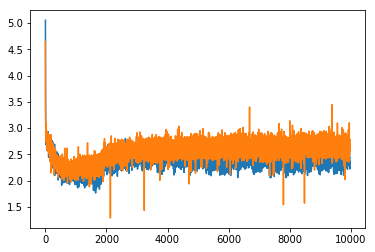

In [17]:
#### SHOW LOSSES ####

utils.show_losses(np.array(training_loss_history)[:,0], np.array(test_loss_history)[:,0])
pkl.dump([training_loss_history, test_loss_history], open('./saved_models/histories.pkl', 'wb'))

In [9]:
#### GET TEST BATCH

batch = next(test_data_gen)
batch = collapse_documents(batch)

In [10]:
#### TESTING ####

importlib.reload(utils)

idx = 0
idx = random.randint(0,10)
print(idx)

answer_preds = answer_model.predict(batch["document_tokens"])

answers = np.squeeze(np.round(answer_preds))
answer_batch = expand_answers(batch, answers)

utils.show_test(batch, answer_batch, idx, answer_model, decoder_initial_state_model, question_model)

#### PLOT ANSWER LIKELIHOOD ####
plt.plot(batch['answer_labels'][idx])
plt.plot(answer_preds[idx])
plt.show()

0

 TEXT
NEW YORK -LRB- CNN -RRB- -- Yet another scale Il Divo has mastered : scaling the heights of success . The quartet was formed in 2004 after a global search . The operatic quartet 's new album , `` The Promise , '' debuted atop the UK charts , their third collection to hit the No. 1 spot . The album -LRB- which was released in the U.S. last Tuesday -RRB- features Leonard Cohen 's `` Hallelujah , '' Frankie Goes to Hollywood 's `` The Power of Love , '' and the traditional `` Amazing Grace . '' Il Divo also takes a chance on the ABBA hit `` The Winner Takes it All . '' The group is the brainchild of `` American Idol '' judge Simon Cowell , who saw a potential market for an international , `` popera '' - style act after the soaring success of the Andrea Bocelli-Sarah Brightman duet `` Time to Say Goodbye -LRB- Con te Partiro -RRB- . '' Watch Il Divo in action '' Formed in 2004 after a global search , Il Divo -LRB- Italian for `` divine male performer '' -RRB- consists of Spanish b

InvalidArgumentError: Tried to read from index -1 but array size is: 0
	 [[{{node encoder_cell/TensorArrayReadV3}} = TensorArrayReadV3[_class=["loc:@train...rayWriteV3"], dtype=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](encoder_cell/TensorArray, encoder_cell/sub_1, encoder_cell/while/Exit_1)]]